# Importanción de librerías 

In [1]:
import tensorflow as tf
import sklearn
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import librosa
from python_speech_features import mfcc
import os

In [2]:
tf.test.is_gpu_available()

True

# Generación de ficheros

Esta función se encarga de generar un archivo txt de manera que este contenga 2 elementos por fila ('name_file','etiqueta') de esta manera permitirá poder entrenar la red.

In [3]:
import numpy as np
import os
def generate_file_data(dir,name):
    directory=dir
    #el nombre de los archivos posee el primer dígito en el nombre de esta forma permitirá etiquetarlos.
    a={'0':'cero','1':'uno','2':'dos','3':'tres','4':'cuatro','5':'cinco','6':'seis','7':'siete','8':'ocho','9':'nueve'}
    da=os.listdir(directory)
    # ordena los archivos
    da.sort()
    file = open(dir+name+'.txt',"w")
    for filename in da:
        if '.wav' in filename:
            file.write(filename+','+a[filename[0]]+'\n')
    file.close() 
    # genera el fichero
    with open(directory+'/'+name+'.txt') as f:
        read_data = f.read()
        f.closed
    read_data=read_data.split('\n')
    read_data=read_data[0:len(read_data)-1]
    return read_data

# Encoding words with One Hot Encoding
En esta sección se usará one hot encoding para representar las palabras

In [4]:
from sklearn.preprocessing import OneHotEncoder
vocabulary_words=np.array(['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve'])

In [5]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore',categories='auto')

In [6]:
onehot_encoder.fit(X=vocabulary_words.reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [7]:
onehot_encoder.categories_

[array(['cero', 'cinco', 'cuatro', 'dos', 'nueve', 'ocho', 'seis', 'siete',
        'tres', 'uno'], dtype='<U6')]

In [8]:
v=onehot_encoder.transform(vocabulary_words.reshape(-1,1)).toarray()

In [9]:
v

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [10]:
onehot_encoder.inverse_transform(v)

array([['cero'],
       ['uno'],
       ['dos'],
       ['tres'],
       ['cuatro'],
       ['cinco'],
       ['seis'],
       ['siete'],
       ['ocho'],
       ['nueve']], dtype='<U6')

### Se muestran las funciones para codificar y decodificar

In [11]:
def encode(x):# tomará un array de string y lo transformada a encode
    return onehot_encoder.transform(x.reshape(-1,1)).toarray()
def decode(x):
    return onehot_encoder.inverse_transform(x)

In [12]:
a=encode(np.array(['uno','dos']))

In [13]:
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [14]:
decode(a)

array([['uno'],
       ['dos']], dtype='<U6')

# MFCC 


In [20]:
def mfcc_features(DIR,list_dir):
    mfcc_audios=[]
    for dir in list_dir:
        wave, sr = librosa.load(DIR+dir, mono=True)
        features= librosa.feature.mfcc(wave, sr,n_mfcc=20)
        features=librosa.feature.delta(features)
        
        #features = sklearn.preprocessing.minmax_scale
        #features=sklearn.preprocessing.normalize(features,axis=1)
        try:
            features=np.pad(features,((0,0),(0,160-len(features[0]))),mode='constant', constant_values=0)
        except OSError as err:
            print(dir)
        scaler = sklearn.preprocessing.StandardScaler()
        features=scaler.fit_transform(features)
        mfcc_audios.append(features)
    mfcc_audios=np.array(mfcc_audios)
    return mfcc_audios

In [21]:
def prepare_data(dir,name):
    file = open(dir+name)
    f=file.read()
    file.close()
    f=f.split('\n')
    f=f[0:len(f)-1]
    labels=[]
    names_audios=[]
    for i in f:
        j=i.split(',')
        names_audios.append(j[0])
        labels.append(j[1])
    labels=np.array(labels)
    onehot= encode(labels)
    mfcc=mfcc_features(dir,names_audios)
    print(name+' OK')
    return mfcc,onehot



In [22]:
class dataset:
    def __init__(self,data):
        self.i=0#para el shuffle
        self.data_dir=data
        self.shuffle=None
        self.dir_training=data+'/training/'
        self.dir_test=data+'/test/'
        self.training_set=None
        self.test_set=None
    def split_dataset(self):
        if os.path.exists(self.dir_training+'training.txt')==False:
            generate_file_data(self.dir_training,name='training')
        if os.path.exists(self.dir_training+'test.txt')==False:
            generate_file_data(self.dir_test,name='test')
        print('loadfiles')
    def prepare(self):
        self.training_set=prepare_data(self.dir_training,'training.txt')
        self.test_set=prepare_data(self.dir_test,'test.txt')

    

In [23]:
d=dataset('data')
d.split_dataset()

loadfiles


In [24]:
d.prepare()

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

training.txt OK


/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

test.txt OK


/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [19]:
scale = sklearn.preprocessing.MinMaxScaler()

In [20]:
def minscale(data):
    for i in data:
        scale.fit(i)
        

# Red neuronal 

En esta sección se definen los distintos modelos a aplicar en este seminario

In [25]:
import sklearn
import tensorflow as tf
import time 
import matplotlib.pyplot as plt
import json
import os

In [26]:
# Se dividen los conjuntos
trainX, trainY = d.training_set[0],d.training_set[1]
testX, testY = d.test_set[0],d.test_set[1]
trainX=np.matrix.transpose(trainX,[0,2,1])
testX=np.matrix.transpose(testX,[0,2,1])

##### A continuación mostramos un elemento del training y test

In [27]:
trainX[0]

array([[ 1.64700507,  1.9945672 ,  1.98824514, ..., -0.53819457,
         0.12530242, -0.33085568],
       [ 1.64700507,  1.9945672 ,  1.98824514, ..., -0.53819457,
         0.12530242, -0.33085568],
       [ 1.64700507,  1.9945672 ,  1.98824514, ..., -0.53819457,
         0.12530242, -0.33085568],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [29]:
trainX[0]

array([[ 1.64700507,  1.9945672 ,  1.98824514, ..., -0.53819457,
         0.12530242, -0.33085568],
       [ 1.64700507,  1.9945672 ,  1.98824514, ..., -0.53819457,
         0.12530242, -0.33085568],
       [ 1.64700507,  1.9945672 ,  1.98824514, ..., -0.53819457,
         0.12530242, -0.33085568],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [27]:
testX=np.array([scale.transform(i) for i in testX])

In [28]:
testX

array([[[ 0.29477372,  0.        ,  0.51545782, ...,  0.4650055 ,
          0.52288985,  0.61232301],
        [ 0.29906835,  0.02024784,  0.56387608, ...,  0.33298813,
          0.38843232,  0.49291624],
        [ 0.31282293,  0.08258129,  0.6970484 , ...,  0.28165512,
          0.34687953,  0.48497778],
        ...,
        [ 1.        ,  0.        ,  0.51545782, ...,  0.4650055 ,
          0.52288985,  0.61232301],
        [ 1.        ,  0.        ,  0.51545782, ...,  0.4650055 ,
          0.52288985,  0.61232301],
        [ 1.        ,  0.        ,  0.51545782, ...,  0.4650055 ,
          0.52288985,  0.61232301]],

       [[ 0.13746074,  0.51679168,  1.06093256, ...,  0.6218253 ,
          0.51352008,  0.81244541],
        [ 0.17236937,  0.47360122,  0.79626235, ...,  0.64032587,
          0.50851148,  0.85233189],
        [ 0.17854422,  0.38254017,  0.56358559, ...,  0.67150158,
          0.71558776,  0.91095523],
        ...,
        [ 1.        ,  0.        ,  0.51545782, ...,  

## Modelos de prueba
A continuación presentamos 4 modelos que serán entrenados para el reconocimiento de voz.

In [30]:
def RNN_simple(name,n_units=128,time_steps=160,n_inputs=20,batch_size=10,n_epochs=500):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.SimpleRNN(128, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [31]:
def LSTM_simple(name,n_units=128,time_steps=160,n_inputs=20,batch_size=10,n_epochs=500):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [32]:
def LSTM_with_Dropout(name,n_units=128,time_steps=160,n_inputs=20,batch_size=10,n_epochs=500,dropout=0.5):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [33]:
def LSTM_with_3layers(name,n_units=128,time_steps=160,n_inputs=20,batch_size=10,n_epochs=500):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs),return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs),return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [46]:
def LSTM_with_2layers_1D(name,dropout,n_units=20,time_steps=160,n_inputs=20,batch_size=10,n_epochs=500):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs),return_sequences=True))
    #model.add(tf.keras.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

## Plotting and saving modelo
Se presentará una función que graficará los resultados y guardará el modelo y sus datos de entrenamiento

In [57]:
def plot_and_saving(history,name):
    dir='Models/Model_'
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Precision del Modelo')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.savefig(dir+name+'/prec')
    plt.show()
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Perdida del modelo')
    plt.ylabel('Perdida')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.savefig(dir+name+'/cost')
    plt.show()
    json.dump(history.history, open('Models/Model_'+name+'/'+name+'_history', 'w'))


# Entrenamiento 
Entrenaremos distintas con los modelos definidos

In [86]:
RNN=RNN_simple('RNNsimple')

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 4s 18ms/step - loss: 2.3309 - acc: 0.0917 - val_loss: 2.3922 - val_acc: 0.0818
Epoch 2/500
240/240 [==============================] - 2s 8ms/step - loss: 2.3627 - acc: 0.1167 - val_loss: 2.3060 - val_acc: 0.1455
Epoch 3/500
240/240 [==============================] - 2s 9ms/step - loss: 2.3560 - acc: 0.1167 - val_loss: 2.3139 - val_acc: 0.1455
Epoch 4/500
240/240 [==============================] - 2s 8ms/step - loss: 2.3453 - acc: 0.0708 - val_loss: 2.3476 - val_acc: 0.0727
Epoch 5/500
240/240 [==============================] - 2s 8ms/step - loss: 2.3626 - acc: 0.1083 - val_loss: 2.3476 - val_acc: 0.1091
Epoch 6/500
240/240 [==============================] - 3s 11ms/step - loss: 2.3184 - acc: 0.1458 - val_loss: 2.3623 - val_acc: 0.1091
Epoch 7/500
240/240 [==============================] - 3s 11ms/step - loss: 2.3359 - acc: 0.1208 - val_loss: 2.4152 - val_acc: 0.0909
Epoch 8/500
240/240 

Epoch 62/500
240/240 [==============================] - 3s 11ms/step - loss: 2.3912 - acc: 0.0917 - val_loss: 2.3418 - val_acc: 0.1273
Epoch 63/500
240/240 [==============================] - 2s 8ms/step - loss: 2.3677 - acc: 0.1042 - val_loss: 2.3362 - val_acc: 0.1273
Epoch 64/500
240/240 [==============================] - 3s 14ms/step - loss: 2.3496 - acc: 0.1167 - val_loss: 2.3347 - val_acc: 0.1091
Epoch 65/500
240/240 [==============================] - 2s 8ms/step - loss: 2.3660 - acc: 0.0917 - val_loss: 2.3255 - val_acc: 0.0727
Epoch 66/500
240/240 [==============================] - 2s 8ms/step - loss: 2.3638 - acc: 0.0833 - val_loss: 2.3151 - val_acc: 0.1091
Epoch 67/500
240/240 [==============================] - 3s 10ms/step - loss: 2.3306 - acc: 0.0750 - val_loss: 2.3368 - val_acc: 0.1636
Epoch 68/500
240/240 [==============================] - 4s 15ms/step - loss: 2.3342 - acc: 0.1167 - val_loss: 2.3305 - val_acc: 0.0727
Epoch 69/500
240/240 [==============================] - 3s

Epoch 123/500
240/240 [==============================] - 2s 8ms/step - loss: 2.2149 - acc: 0.1833 - val_loss: 2.4714 - val_acc: 0.0727
Epoch 124/500
240/240 [==============================] - 2s 8ms/step - loss: 2.2156 - acc: 0.2000 - val_loss: 2.4743 - val_acc: 0.0818
Epoch 125/500
240/240 [==============================] - 3s 11ms/step - loss: 2.2218 - acc: 0.1750 - val_loss: 2.4809 - val_acc: 0.0909
Epoch 126/500
240/240 [==============================] - 2s 9ms/step - loss: 2.2081 - acc: 0.1792 - val_loss: 2.4545 - val_acc: 0.1000
Epoch 127/500
240/240 [==============================] - 2s 8ms/step - loss: 2.2161 - acc: 0.1750 - val_loss: 2.4710 - val_acc: 0.0909
Epoch 128/500
240/240 [==============================] - 2s 10ms/step - loss: 2.2069 - acc: 0.1792 - val_loss: 2.4896 - val_acc: 0.0909
Epoch 129/500
240/240 [==============================] - 3s 13ms/step - loss: 2.2179 - acc: 0.1875 - val_loss: 2.4684 - val_acc: 0.0636
Epoch 130/500
240/240 [=============================

240/240 [==============================] - 2s 8ms/step - loss: 2.1210 - acc: 0.1708 - val_loss: 2.7573 - val_acc: 0.1273
Epoch 244/500
240/240 [==============================] - 2s 9ms/step - loss: 2.1046 - acc: 0.2125 - val_loss: 2.7242 - val_acc: 0.1182
Epoch 245/500
240/240 [==============================] - 2s 9ms/step - loss: 2.0954 - acc: 0.2208 - val_loss: 2.7329 - val_acc: 0.1000
Epoch 246/500
240/240 [==============================] - 2s 9ms/step - loss: 2.1082 - acc: 0.2042 - val_loss: 2.7284 - val_acc: 0.1273
Epoch 247/500
240/240 [==============================] - 2s 10ms/step - loss: 2.1085 - acc: 0.1750 - val_loss: 2.7346 - val_acc: 0.1091
Epoch 248/500
240/240 [==============================] - 2s 10ms/step - loss: 2.0982 - acc: 0.1917 - val_loss: 2.7316 - val_acc: 0.1273
Epoch 249/500
240/240 [==============================] - 2s 9ms/step - loss: 2.0996 - acc: 0.2167 - val_loss: 2.7327 - val_acc: 0.1000
Epoch 250/500
240/240 [==============================] - 2s 9ms/ste

Epoch 304/500
240/240 [==============================] - 2s 8ms/step - loss: 2.1031 - acc: 0.2083 - val_loss: 2.7923 - val_acc: 0.1091
Epoch 305/500
240/240 [==============================] - 2s 7ms/step - loss: 2.0978 - acc: 0.2250 - val_loss: 2.7915 - val_acc: 0.1091
Epoch 306/500
240/240 [==============================] - 2s 7ms/step - loss: 2.0997 - acc: 0.2000 - val_loss: 2.8135 - val_acc: 0.1182
Epoch 307/500
240/240 [==============================] - 2s 8ms/step - loss: 2.0951 - acc: 0.1833 - val_loss: 2.8378 - val_acc: 0.0727
Epoch 308/500
240/240 [==============================] - 3s 11ms/step - loss: 2.0946 - acc: 0.2042 - val_loss: 2.8240 - val_acc: 0.1364
Epoch 309/500
240/240 [==============================] - 2s 10ms/step - loss: 2.0984 - acc: 0.2042 - val_loss: 2.8098 - val_acc: 0.1091
Epoch 310/500
240/240 [==============================] - 2s 9ms/step - loss: 2.1051 - acc: 0.2083 - val_loss: 2.8305 - val_acc: 0.0455
Epoch 311/500
240/240 [==============================

Epoch 425/500
240/240 [==============================] - 2s 8ms/step - loss: 2.1080 - acc: 0.2167 - val_loss: 2.8616 - val_acc: 0.1182
Epoch 426/500
240/240 [==============================] - 2s 8ms/step - loss: 2.1083 - acc: 0.1958 - val_loss: 2.8513 - val_acc: 0.1091
Epoch 427/500
240/240 [==============================] - 2s 8ms/step - loss: 2.0823 - acc: 0.2125 - val_loss: 2.8648 - val_acc: 0.1000
Epoch 428/500
240/240 [==============================] - 2s 8ms/step - loss: 2.1107 - acc: 0.1917 - val_loss: 2.8649 - val_acc: 0.1091
Epoch 429/500
240/240 [==============================] - 2s 8ms/step - loss: 2.1011 - acc: 0.2125 - val_loss: 2.8493 - val_acc: 0.1182
Epoch 430/500
240/240 [==============================] - 2s 8ms/step - loss: 2.1054 - acc: 0.1958 - val_loss: 2.8650 - val_acc: 0.1182
Epoch 431/500
240/240 [==============================] - 2s 9ms/step - loss: 2.0988 - acc: 0.2083 - val_loss: 2.8565 - val_acc: 0.1182
Epoch 432/500
240/240 [==============================] 

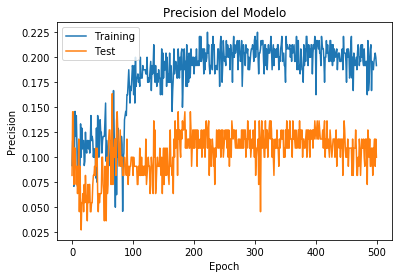

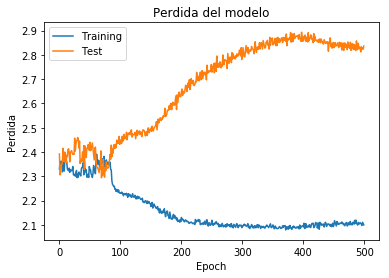

In [103]:
plot_and_saving(RNN,'RNNsimple')

In [35]:
LSTM_SIMPLE=LSTM_simple(name='LSTM_simpledelta')

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 9s 39ms/step - loss: 2.3051 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 2/500
240/240 [==============================] - 7s 29ms/step - loss: 2.3039 - acc: 0.0625 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/500
240/240 [==============================] - 6s 24ms/step - loss: 2.3033 - acc: 0.0875 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/500
240/240 [==============================] - 6s 24ms/step - loss: 2.3004 - acc: 0.0917 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/500
240/240 [==============================] - 7s 27ms/step - loss: 2.3043 - acc: 0.0625 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/500
240/240 [==============================] - 7s 30ms/step - loss: 2.3010 - acc: 0.0542 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/500
240/240 [==============================] - 6s 23ms/step - loss: 2.2973 - acc: 0.0583 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 8/500
240/

240/240 [==============================] - 5s 23ms/step - loss: 2.3270 - acc: 0.0625 - val_loss: 2.3049 - val_acc: 0.1000
Epoch 62/500
240/240 [==============================] - 6s 23ms/step - loss: 2.3119 - acc: 0.0958 - val_loss: 2.3043 - val_acc: 0.1000
Epoch 63/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3107 - acc: 0.0833 - val_loss: 2.3033 - val_acc: 0.1000
Epoch 64/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3226 - acc: 0.0792 - val_loss: 2.3063 - val_acc: 0.1000
Epoch 65/500
240/240 [==============================] - 6s 25ms/step - loss: 2.3249 - acc: 0.0792 - val_loss: 2.3045 - val_acc: 0.1000
Epoch 66/500
240/240 [==============================] - 8s 31ms/step - loss: 2.3151 - acc: 0.0875 - val_loss: 2.3046 - val_acc: 0.0909
Epoch 67/500
240/240 [==============================] - 6s 25ms/step - loss: 2.3109 - acc: 0.0708 - val_loss: 2.3042 - val_acc: 0.1000
Epoch 68/500
240/240 [==============================] - 6s 25ms/step

240/240 [==============================] - 7s 30ms/step - loss: 2.2679 - acc: 0.1458 - val_loss: 2.2799 - val_acc: 0.1818
Epoch 122/500
240/240 [==============================] - 6s 25ms/step - loss: 2.2728 - acc: 0.1750 - val_loss: 2.2979 - val_acc: 0.1182
Epoch 123/500
240/240 [==============================] - 6s 23ms/step - loss: 2.3060 - acc: 0.1250 - val_loss: 2.3133 - val_acc: 0.1182
Epoch 124/500
240/240 [==============================] - 6s 23ms/step - loss: 2.3365 - acc: 0.0875 - val_loss: 2.3413 - val_acc: 0.0909
Epoch 125/500
240/240 [==============================] - 8s 33ms/step - loss: 2.3521 - acc: 0.0750 - val_loss: 2.3356 - val_acc: 0.0909
Epoch 126/500
240/240 [==============================] - 9s 37ms/step - loss: 2.3486 - acc: 0.0625 - val_loss: 2.3194 - val_acc: 0.0818
Epoch 127/500
240/240 [==============================] - 7s 30ms/step - loss: 2.3304 - acc: 0.0958 - val_loss: 2.3235 - val_acc: 0.1000
Epoch 128/500
240/240 [==============================] - 6s 25

240/240 [==============================] - 6s 23ms/step - loss: 1.8431 - acc: 0.3333 - val_loss: 1.9982 - val_acc: 0.2727
Epoch 182/500
240/240 [==============================] - 6s 26ms/step - loss: 1.7958 - acc: 0.2875 - val_loss: 1.9454 - val_acc: 0.2727
Epoch 183/500
240/240 [==============================] - 5s 22ms/step - loss: 1.8430 - acc: 0.2833 - val_loss: 1.9654 - val_acc: 0.2545
Epoch 184/500
240/240 [==============================] - 5s 22ms/step - loss: 1.9007 - acc: 0.2708 - val_loss: 1.9680 - val_acc: 0.3000
Epoch 185/500
240/240 [==============================] - 5s 23ms/step - loss: 1.8394 - acc: 0.3000 - val_loss: 1.9340 - val_acc: 0.3091
Epoch 186/500
240/240 [==============================] - 5s 22ms/step - loss: 1.7536 - acc: 0.3458 - val_loss: 1.9446 - val_acc: 0.2818
Epoch 187/500
240/240 [==============================] - 5s 22ms/step - loss: 1.7715 - acc: 0.3250 - val_loss: 2.0309 - val_acc: 0.3000
Epoch 188/500
240/240 [==============================] - 9s 37

240/240 [==============================] - 9s 38ms/step - loss: 1.2043 - acc: 0.5042 - val_loss: 1.5850 - val_acc: 0.4273
Epoch 242/500
240/240 [==============================] - 6s 25ms/step - loss: 1.2008 - acc: 0.5083 - val_loss: 1.5893 - val_acc: 0.4000
Epoch 243/500
240/240 [==============================] - 6s 23ms/step - loss: 1.1586 - acc: 0.5583 - val_loss: 1.5117 - val_acc: 0.4364
Epoch 244/500
240/240 [==============================] - 5s 23ms/step - loss: 1.1380 - acc: 0.5333 - val_loss: 1.4989 - val_acc: 0.4545
Epoch 245/500
240/240 [==============================] - 6s 23ms/step - loss: 1.1394 - acc: 0.5042 - val_loss: 1.4891 - val_acc: 0.4182
Epoch 246/500
240/240 [==============================] - 6s 23ms/step - loss: 1.1809 - acc: 0.5417 - val_loss: 1.4836 - val_acc: 0.4455
Epoch 247/500
240/240 [==============================] - 6s 23ms/step - loss: 1.1664 - acc: 0.5208 - val_loss: 1.5489 - val_acc: 0.3818
Epoch 248/500
240/240 [==============================] - 5s 23

240/240 [==============================] - 6s 25ms/step - loss: 1.4210 - acc: 0.4792 - val_loss: 1.6952 - val_acc: 0.3091
Epoch 302/500
240/240 [==============================] - 6s 23ms/step - loss: 1.3727 - acc: 0.5333 - val_loss: 1.7272 - val_acc: 0.3273
Epoch 303/500
240/240 [==============================] - 5s 22ms/step - loss: 1.3944 - acc: 0.4750 - val_loss: 1.6176 - val_acc: 0.3818
Epoch 304/500
240/240 [==============================] - 5s 23ms/step - loss: 1.3020 - acc: 0.5250 - val_loss: 1.6141 - val_acc: 0.3545
Epoch 305/500
240/240 [==============================] - 6s 24ms/step - loss: 1.3254 - acc: 0.5167 - val_loss: 1.6556 - val_acc: 0.4000
Epoch 306/500
240/240 [==============================] - 5s 22ms/step - loss: 1.2236 - acc: 0.5500 - val_loss: 1.5947 - val_acc: 0.4000
Epoch 307/500
240/240 [==============================] - 5s 22ms/step - loss: 1.1803 - acc: 0.5708 - val_loss: 1.6163 - val_acc: 0.3545
Epoch 308/500
240/240 [==============================] - 5s 22

240/240 [==============================] - 6s 23ms/step - loss: 0.7544 - acc: 0.7292 - val_loss: 1.6575 - val_acc: 0.4909
Epoch 362/500
240/240 [==============================] - 6s 24ms/step - loss: 0.7300 - acc: 0.7458 - val_loss: 1.6328 - val_acc: 0.5091
Epoch 363/500
240/240 [==============================] - 6s 23ms/step - loss: 0.7177 - acc: 0.7500 - val_loss: 1.6060 - val_acc: 0.5091
Epoch 364/500
240/240 [==============================] - 6s 24ms/step - loss: 0.7118 - acc: 0.7458 - val_loss: 1.6121 - val_acc: 0.5091
Epoch 365/500
240/240 [==============================] - 6s 25ms/step - loss: 0.7057 - acc: 0.7375 - val_loss: 1.6267 - val_acc: 0.4818
Epoch 366/500
240/240 [==============================] - 6s 23ms/step - loss: 0.7044 - acc: 0.7500 - val_loss: 1.6436 - val_acc: 0.5182
Epoch 367/500
240/240 [==============================] - 6s 23ms/step - loss: 0.7017 - acc: 0.7500 - val_loss: 1.6620 - val_acc: 0.5091
Epoch 368/500
240/240 [==============================] - 6s 25

240/240 [==============================] - 7s 29ms/step - loss: 0.8566 - acc: 0.6917 - val_loss: 1.6747 - val_acc: 0.4636
Epoch 422/500
240/240 [==============================] - 7s 31ms/step - loss: 0.8007 - acc: 0.7250 - val_loss: 1.7068 - val_acc: 0.4455
Epoch 423/500
240/240 [==============================] - 7s 28ms/step - loss: 0.7990 - acc: 0.7125 - val_loss: 1.6444 - val_acc: 0.4727
Epoch 424/500
240/240 [==============================] - 7s 30ms/step - loss: 0.7943 - acc: 0.7208 - val_loss: 1.5944 - val_acc: 0.4818
Epoch 425/500
240/240 [==============================] - 7s 31ms/step - loss: 0.9125 - acc: 0.6458 - val_loss: 1.6257 - val_acc: 0.4273
Epoch 426/500
240/240 [==============================] - 6s 25ms/step - loss: 0.8830 - acc: 0.6500 - val_loss: 1.5983 - val_acc: 0.4182
Epoch 427/500
240/240 [==============================] - 6s 26ms/step - loss: 0.8381 - acc: 0.6708 - val_loss: 1.6788 - val_acc: 0.4455
Epoch 428/500
240/240 [==============================] - 7s 30

240/240 [==============================] - 6s 24ms/step - loss: 0.5717 - acc: 0.7917 - val_loss: 1.8170 - val_acc: 0.4909
Epoch 482/500
240/240 [==============================] - 6s 25ms/step - loss: 0.5672 - acc: 0.7958 - val_loss: 1.7963 - val_acc: 0.4909
Epoch 483/500
240/240 [==============================] - 6s 27ms/step - loss: 0.5660 - acc: 0.7958 - val_loss: 1.8159 - val_acc: 0.4909
Epoch 484/500
240/240 [==============================] - 7s 30ms/step - loss: 0.5631 - acc: 0.7958 - val_loss: 1.8305 - val_acc: 0.4909
Epoch 485/500
240/240 [==============================] - 6s 26ms/step - loss: 0.5635 - acc: 0.7958 - val_loss: 1.8352 - val_acc: 0.4909
Epoch 486/500
240/240 [==============================] - 6s 23ms/step - loss: 0.5639 - acc: 0.7958 - val_loss: 1.8288 - val_acc: 0.4909
Epoch 487/500
240/240 [==============================] - 6s 23ms/step - loss: 0.5637 - acc: 0.7958 - val_loss: 1.8395 - val_acc: 0.4909
Epoch 488/500
240/240 [==============================] - 8s 32

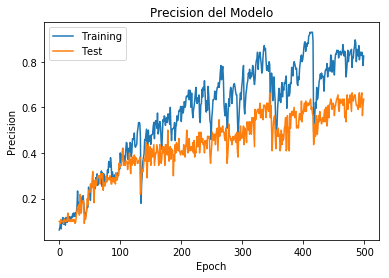

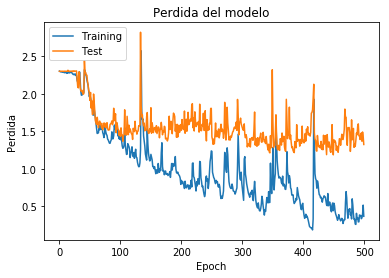

In [104]:
plot_and_saving(LSTM_SIMPLE,name='LSTM_simple')

In [111]:
LSTMD=LSTM_with_Dropout('LSTM_Dropout0.5',dropout=0.5)

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 10s 40ms/step - loss: 2.3052 - acc: 0.0917 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/500
240/240 [==============================] - 7s 31ms/step - loss: 2.2981 - acc: 0.0875 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/500
240/240 [==============================] - 6s 27ms/step - loss: 2.2939 - acc: 0.0875 - val_loss: 2.3018 - val_acc: 0.1182
Epoch 4/500
240/240 [==============================] - 7s 30ms/step - loss: 2.2910 - acc: 0.0833 - val_loss: 2.3031 - val_acc: 0.1000
Epoch 5/500
240/240 [==============================] - 6s 26ms/step - loss: 2.2942 - acc: 0.0792 - val_loss: 2.3031 - val_acc: 0.1000
Epoch 6/500
240/240 [==============================] - 7s 28ms/step - loss: 2.2911 - acc: 0.0542 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/500
240/240 [==============================] - 6s 25ms/step - loss: 2.2966 - acc: 0.0917 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 8/500
240

240/240 [==============================] - 8s 35ms/step - loss: 2.2222 - acc: 0.0958 - val_loss: 2.2874 - val_acc: 0.1091
Epoch 122/500
240/240 [==============================] - 7s 30ms/step - loss: 2.2091 - acc: 0.1542 - val_loss: 2.2832 - val_acc: 0.1273
Epoch 123/500
240/240 [==============================] - 7s 30ms/step - loss: 2.2153 - acc: 0.1250 - val_loss: 2.2981 - val_acc: 0.1273
Epoch 124/500
240/240 [==============================] - 7s 30ms/step - loss: 2.2093 - acc: 0.1250 - val_loss: 2.2708 - val_acc: 0.1455
Epoch 125/500
240/240 [==============================] - 7s 28ms/step - loss: 2.1859 - acc: 0.1750 - val_loss: 2.2831 - val_acc: 0.1182
Epoch 126/500
240/240 [==============================] - 8s 35ms/step - loss: 2.1556 - acc: 0.1500 - val_loss: 2.2090 - val_acc: 0.1273
Epoch 127/500
240/240 [==============================] - 7s 30ms/step - loss: 2.0757 - acc: 0.1875 - val_loss: 2.1290 - val_acc: 0.2273
Epoch 128/500
240/240 [==============================] - 7s 31

240/240 [==============================] - 7s 28ms/step - loss: 1.1517 - acc: 0.4583 - val_loss: 1.6872 - val_acc: 0.3727
Epoch 242/500
240/240 [==============================] - 9s 39ms/step - loss: 1.0868 - acc: 0.5125 - val_loss: 1.6366 - val_acc: 0.3818
Epoch 243/500
240/240 [==============================] - 8s 32ms/step - loss: 1.0302 - acc: 0.5250 - val_loss: 1.7573 - val_acc: 0.3455
Epoch 244/500
240/240 [==============================] - 7s 29ms/step - loss: 0.9944 - acc: 0.5500 - val_loss: 1.6710 - val_acc: 0.3818
Epoch 245/500
240/240 [==============================] - 8s 32ms/step - loss: 1.0281 - acc: 0.5417 - val_loss: 1.7191 - val_acc: 0.4091
Epoch 246/500
240/240 [==============================] - 8s 31ms/step - loss: 1.0131 - acc: 0.5292 - val_loss: 1.8062 - val_acc: 0.3364
Epoch 247/500
240/240 [==============================] - 8s 34ms/step - loss: 0.9744 - acc: 0.5583 - val_loss: 1.7000 - val_acc: 0.4364
Epoch 248/500
240/240 [==============================] - 7s 28

240/240 [==============================] - 8s 32ms/step - loss: 0.5420 - acc: 0.7833 - val_loss: 1.8416 - val_acc: 0.5091
Epoch 362/500
240/240 [==============================] - 8s 32ms/step - loss: 0.5721 - acc: 0.7542 - val_loss: 1.8909 - val_acc: 0.4818
Epoch 363/500
240/240 [==============================] - 7s 30ms/step - loss: 0.5975 - acc: 0.7625 - val_loss: 1.8884 - val_acc: 0.5273
Epoch 364/500
240/240 [==============================] - 9s 36ms/step - loss: 0.6770 - acc: 0.7417 - val_loss: 2.1028 - val_acc: 0.4455
Epoch 365/500
240/240 [==============================] - 7s 31ms/step - loss: 0.6130 - acc: 0.7542 - val_loss: 1.8056 - val_acc: 0.5455
Epoch 366/500
240/240 [==============================] - 5s 22ms/step - loss: 0.5454 - acc: 0.7708 - val_loss: 1.9199 - val_acc: 0.5364
Epoch 367/500
240/240 [==============================] - 6s 26ms/step - loss: 0.5891 - acc: 0.7417 - val_loss: 1.8778 - val_acc: 0.5182
Epoch 368/500
240/240 [==============================] - 6s 27

240/240 [==============================] - 5s 22ms/step - loss: 0.2179 - acc: 0.9000 - val_loss: 1.7982 - val_acc: 0.5818
Epoch 482/500
240/240 [==============================] - 5s 22ms/step - loss: 0.2163 - acc: 0.9083 - val_loss: 1.8698 - val_acc: 0.5727
Epoch 483/500
240/240 [==============================] - 5s 22ms/step - loss: 0.2074 - acc: 0.9250 - val_loss: 1.8810 - val_acc: 0.5727
Epoch 484/500
240/240 [==============================] - 5s 22ms/step - loss: 0.2044 - acc: 0.9125 - val_loss: 1.7563 - val_acc: 0.5909
Epoch 485/500
240/240 [==============================] - 5s 22ms/step - loss: 0.1747 - acc: 0.9333 - val_loss: 1.7778 - val_acc: 0.6000
Epoch 486/500
240/240 [==============================] - 5s 22ms/step - loss: 0.1674 - acc: 0.9208 - val_loss: 1.8770 - val_acc: 0.5455
Epoch 487/500
240/240 [==============================] - 5s 22ms/step - loss: 0.1615 - acc: 0.9333 - val_loss: 1.8551 - val_acc: 0.5818
Epoch 488/500
240/240 [==============================] - 5s 22

In [ ]:
LSTMD=LSTM_with_Dropout('LSTM_Dropoutdelta0.8',dropout=0.8)

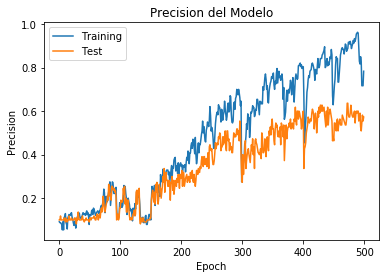

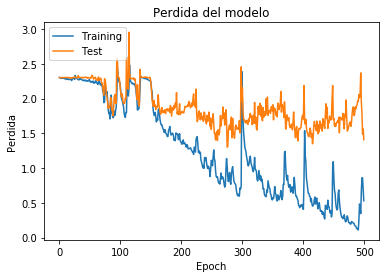

In [112]:
plot_and_saving(LSTMD,name='LSTM_Dropout')

In [118]:
Lstm_mlayer=LSTM_with_3layers('LSTM3layer')

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 21s 87ms/step - loss: 2.3062 - acc: 0.0750 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 2/500
240/240 [==============================] - 17s 72ms/step - loss: 2.3005 - acc: 0.1042 - val_loss: 2.3038 - val_acc: 0.1091
Epoch 3/500
240/240 [==============================] - 18s 73ms/step - loss: 2.2983 - acc: 0.1167 - val_loss: 2.3034 - val_acc: 0.0909
Epoch 4/500
240/240 [==============================] - 17s 72ms/step - loss: 2.2946 - acc: 0.0917 - val_loss: 2.3054 - val_acc: 0.1091
Epoch 5/500
240/240 [==============================] - 18s 73ms/step - loss: 2.2933 - acc: 0.1000 - val_loss: 2.3078 - val_acc: 0.1000
Epoch 6/500
240/240 [==============================] - 21s 88ms/step - loss: 2.2876 - acc: 0.0792 - val_loss: 2.3051 - val_acc: 0.0909
Epoch 7/500
240/240 [==============================] - 17s 69ms/step - loss: 2.2893 - acc: 0.1000 - val_loss: 2.3128 - val_acc: 0.0909
Epoch 8/5

Epoch 61/500
240/240 [==============================] - 28s 115ms/step - loss: 2.1414 - acc: 0.1917 - val_loss: 2.4123 - val_acc: 0.1182
Epoch 62/500
240/240 [==============================] - 25s 106ms/step - loss: 2.2533 - acc: 0.1625 - val_loss: 2.3141 - val_acc: 0.1000
Epoch 63/500
240/240 [==============================] - 25s 104ms/step - loss: 2.2549 - acc: 0.1208 - val_loss: 2.3236 - val_acc: 0.0909
Epoch 64/500
240/240 [==============================] - 24s 100ms/step - loss: 2.1941 - acc: 0.1583 - val_loss: 2.3801 - val_acc: 0.1182
Epoch 65/500
240/240 [==============================] - 22s 94ms/step - loss: 2.2330 - acc: 0.1167 - val_loss: 2.3543 - val_acc: 0.0909
Epoch 66/500
240/240 [==============================] - 23s 94ms/step - loss: 2.1900 - acc: 0.1625 - val_loss: 2.3574 - val_acc: 0.1364
Epoch 67/500
240/240 [==============================] - 23s 95ms/step - loss: 2.0908 - acc: 0.2250 - val_loss: 2.4447 - val_acc: 0.1364
Epoch 68/500
240/240 [======================

240/240 [==============================] - 24s 99ms/step - loss: 1.5715 - acc: 0.4125 - val_loss: 2.7473 - val_acc: 0.2091
Epoch 122/500
240/240 [==============================] - 23s 94ms/step - loss: 1.6903 - acc: 0.3750 - val_loss: 2.8236 - val_acc: 0.1182
Epoch 123/500
240/240 [==============================] - 19s 80ms/step - loss: 1.9161 - acc: 0.2875 - val_loss: 2.4801 - val_acc: 0.1636
Epoch 124/500
240/240 [==============================] - 22s 90ms/step - loss: 1.9684 - acc: 0.3292 - val_loss: 2.4614 - val_acc: 0.1364
Epoch 125/500
240/240 [==============================] - 27s 112ms/step - loss: 1.6217 - acc: 0.3750 - val_loss: 2.6264 - val_acc: 0.2000
Epoch 126/500
240/240 [==============================] - 26s 107ms/step - loss: 1.5883 - acc: 0.4208 - val_loss: 2.8091 - val_acc: 0.1455
Epoch 127/500
240/240 [==============================] - 24s 100ms/step - loss: 1.6167 - acc: 0.3958 - val_loss: 2.7133 - val_acc: 0.1636
Epoch 128/500
240/240 [=============================

Epoch 181/500
240/240 [==============================] - 18s 76ms/step - loss: 0.8491 - acc: 0.6750 - val_loss: 2.7114 - val_acc: 0.3000
Epoch 182/500
240/240 [==============================] - 18s 74ms/step - loss: 0.8789 - acc: 0.6375 - val_loss: 2.8324 - val_acc: 0.2909
Epoch 183/500
240/240 [==============================] - 17s 72ms/step - loss: 0.8819 - acc: 0.6583 - val_loss: 2.8509 - val_acc: 0.3182
Epoch 184/500
240/240 [==============================] - 17s 72ms/step - loss: 0.8844 - acc: 0.6708 - val_loss: 2.9585 - val_acc: 0.3000
Epoch 185/500
240/240 [==============================] - 17s 70ms/step - loss: 0.9635 - acc: 0.6333 - val_loss: 2.7405 - val_acc: 0.2727
Epoch 186/500
240/240 [==============================] - 17s 70ms/step - loss: 1.4078 - acc: 0.5333 - val_loss: 3.2745 - val_acc: 0.1909
Epoch 187/500
240/240 [==============================] - 25s 104ms/step - loss: 1.4395 - acc: 0.5208 - val_loss: 2.6636 - val_acc: 0.2545
Epoch 188/500
240/240 [=================

Epoch 300/500
240/240 [==============================] - 18s 76ms/step - loss: 0.2127 - acc: 0.9208 - val_loss: 4.5536 - val_acc: 0.2455
Epoch 301/500
240/240 [==============================] - 18s 73ms/step - loss: 0.2347 - acc: 0.9375 - val_loss: 4.6214 - val_acc: 0.2273
Epoch 302/500
240/240 [==============================] - 17s 72ms/step - loss: 0.2206 - acc: 0.9375 - val_loss: 4.5938 - val_acc: 0.2091
Epoch 303/500
240/240 [==============================] - 18s 74ms/step - loss: 0.1955 - acc: 0.9333 - val_loss: 4.6530 - val_acc: 0.2455
Epoch 304/500
240/240 [==============================] - 17s 71ms/step - loss: 0.1707 - acc: 0.9583 - val_loss: 4.8936 - val_acc: 0.2818
Epoch 305/500
240/240 [==============================] - 17s 71ms/step - loss: 0.4457 - acc: 0.8417 - val_loss: 4.3116 - val_acc: 0.2545
Epoch 306/500
240/240 [==============================] - 17s 72ms/step - loss: 0.3579 - acc: 0.8792 - val_loss: 4.3647 - val_acc: 0.2818
Epoch 307/500
240/240 [==================

Epoch 360/500
240/240 [==============================] - 16s 66ms/step - loss: 0.3240 - acc: 0.8875 - val_loss: 4.9910 - val_acc: 0.2636
Epoch 361/500
240/240 [==============================] - 16s 66ms/step - loss: 0.3486 - acc: 0.8833 - val_loss: 5.2892 - val_acc: 0.2455
Epoch 362/500
240/240 [==============================] - 16s 66ms/step - loss: 1.0428 - acc: 0.7125 - val_loss: 3.2515 - val_acc: 0.3182
Epoch 363/500
240/240 [==============================] - 16s 67ms/step - loss: 0.8679 - acc: 0.7292 - val_loss: 3.7247 - val_acc: 0.3182
Epoch 364/500
240/240 [==============================] - 16s 67ms/step - loss: 0.5179 - acc: 0.8167 - val_loss: 3.7212 - val_acc: 0.2545
Epoch 365/500
240/240 [==============================] - 16s 66ms/step - loss: 0.5547 - acc: 0.8125 - val_loss: 3.7941 - val_acc: 0.2636
Epoch 366/500
240/240 [==============================] - 16s 66ms/step - loss: 0.6015 - acc: 0.8500 - val_loss: 3.8550 - val_acc: 0.2818
Epoch 367/500
240/240 [==================

Epoch 420/500
240/240 [==============================] - 16s 66ms/step - loss: 0.9040 - acc: 0.7333 - val_loss: 3.2956 - val_acc: 0.3000
Epoch 421/500
240/240 [==============================] - 16s 66ms/step - loss: 0.6616 - acc: 0.8208 - val_loss: 3.4428 - val_acc: 0.2364
Epoch 422/500
240/240 [==============================] - 16s 66ms/step - loss: 0.4701 - acc: 0.8458 - val_loss: 3.4261 - val_acc: 0.2455
Epoch 423/500
240/240 [==============================] - 16s 66ms/step - loss: 0.4104 - acc: 0.8708 - val_loss: 3.2395 - val_acc: 0.2909
Epoch 424/500
240/240 [==============================] - 16s 66ms/step - loss: 0.3402 - acc: 0.9042 - val_loss: 3.8766 - val_acc: 0.2636
Epoch 425/500
240/240 [==============================] - 16s 66ms/step - loss: 0.3134 - acc: 0.9000 - val_loss: 3.8041 - val_acc: 0.2818
Epoch 426/500
240/240 [==============================] - 16s 66ms/step - loss: 0.4319 - acc: 0.8583 - val_loss: 3.8249 - val_acc: 0.2182
Epoch 427/500
240/240 [==================

Epoch 480/500
240/240 [==============================] - 16s 66ms/step - loss: 1.6576 - acc: 0.4125 - val_loss: 2.3777 - val_acc: 0.2273
Epoch 481/500
240/240 [==============================] - 16s 66ms/step - loss: 1.4062 - acc: 0.5292 - val_loss: 2.3859 - val_acc: 0.2091
Epoch 482/500
240/240 [==============================] - 16s 66ms/step - loss: 1.2705 - acc: 0.5833 - val_loss: 2.4352 - val_acc: 0.2545
Epoch 483/500
240/240 [==============================] - 16s 66ms/step - loss: 1.1624 - acc: 0.6042 - val_loss: 2.5391 - val_acc: 0.2545
Epoch 484/500
240/240 [==============================] - 16s 67ms/step - loss: 1.0401 - acc: 0.6417 - val_loss: 2.6001 - val_acc: 0.2455
Epoch 485/500
240/240 [==============================] - 16s 66ms/step - loss: 0.9551 - acc: 0.6542 - val_loss: 2.4162 - val_acc: 0.2636
Epoch 486/500
240/240 [==============================] - 16s 66ms/step - loss: 0.8223 - acc: 0.7083 - val_loss: 2.6568 - val_acc: 0.2364
Epoch 487/500
240/240 [==================

# Delta 

In [50]:
LSTMDD5=LSTM_with_Dropout('LSTM_Dropoutdelta5',dropout=0.5)

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 7s 29ms/step - loss: 2.3046 - acc: 0.0583 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/500
240/240 [==============================] - 6s 23ms/step - loss: 2.3037 - acc: 0.0667 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/500
240/240 [==============================] - 6s 23ms/step - loss: 2.3024 - acc: 0.0917 - val_loss: 2.3026 - val_acc: 0.0909
Epoch 4/500
240/240 [==============================] - 6s 23ms/step - loss: 2.3018 - acc: 0.0667 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/500
240/240 [==============================] - 6s 23ms/step - loss: 2.2999 - acc: 0.0583 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/500
240/240 [==============================] - 6s 23ms/step - loss: 2.2959 - acc: 0.1083 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/500
240/240 [==============================] - 6s 23ms/step - loss: 2.2948 - acc: 0.0750 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 8/500
240/

240/240 [==============================] - 5s 23ms/step - loss: 2.3046 - acc: 0.0625 - val_loss: 2.2593 - val_acc: 0.1273
Epoch 62/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3053 - acc: 0.0917 - val_loss: 2.2664 - val_acc: 0.1182
Epoch 63/500
240/240 [==============================] - 6s 23ms/step - loss: 2.2966 - acc: 0.0833 - val_loss: 2.2845 - val_acc: 0.1273
Epoch 64/500
240/240 [==============================] - 5s 23ms/step - loss: 2.2993 - acc: 0.0750 - val_loss: 2.2644 - val_acc: 0.1273
Epoch 65/500
240/240 [==============================] - 5s 23ms/step - loss: 2.2974 - acc: 0.0958 - val_loss: 2.2612 - val_acc: 0.1273
Epoch 66/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3021 - acc: 0.0917 - val_loss: 2.2663 - val_acc: 0.1273
Epoch 67/500
240/240 [==============================] - 5s 23ms/step - loss: 2.2957 - acc: 0.0708 - val_loss: 2.2858 - val_acc: 0.1273
Epoch 68/500
240/240 [==============================] - 6s 23ms/step

240/240 [==============================] - 5s 23ms/step - loss: 2.3081 - acc: 0.0792 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 122/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3091 - acc: 0.0583 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 123/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3085 - acc: 0.0750 - val_loss: 2.3030 - val_acc: 0.1000
Epoch 124/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3085 - acc: 0.0542 - val_loss: 2.3031 - val_acc: 0.1000
Epoch 125/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3094 - acc: 0.0542 - val_loss: 2.3031 - val_acc: 0.1000
Epoch 126/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3123 - acc: 0.1000 - val_loss: 2.3035 - val_acc: 0.1000
Epoch 127/500
240/240 [==============================] - 5s 23ms/step - loss: 2.3112 - acc: 0.0667 - val_loss: 2.3036 - val_acc: 0.1000
Epoch 128/500
240/240 [==============================] - 5s 23

240/240 [==============================] - 5s 22ms/step - loss: 1.9152 - acc: 0.2500 - val_loss: 1.9900 - val_acc: 0.2909
Epoch 182/500
240/240 [==============================] - 5s 23ms/step - loss: 1.8747 - acc: 0.2458 - val_loss: 2.2010 - val_acc: 0.1364
Epoch 183/500
240/240 [==============================] - 5s 22ms/step - loss: 2.1480 - acc: 0.1833 - val_loss: 2.0501 - val_acc: 0.2455
Epoch 184/500
240/240 [==============================] - 5s 22ms/step - loss: 2.1033 - acc: 0.1958 - val_loss: 2.2802 - val_acc: 0.1727
Epoch 185/500
240/240 [==============================] - 7s 29ms/step - loss: 2.2135 - acc: 0.1458 - val_loss: 2.0844 - val_acc: 0.1636
Epoch 186/500
240/240 [==============================] - 8s 32ms/step - loss: 1.9943 - acc: 0.2083 - val_loss: 2.0625 - val_acc: 0.2273
Epoch 187/500
240/240 [==============================] - 8s 32ms/step - loss: 2.1876 - acc: 0.1917 - val_loss: 2.2273 - val_acc: 0.1545
Epoch 188/500
240/240 [==============================] - 8s 32

240/240 [==============================] - 5s 22ms/step - loss: 1.4275 - acc: 0.3917 - val_loss: 1.8666 - val_acc: 0.2636
Epoch 242/500
240/240 [==============================] - 8s 32ms/step - loss: 1.3168 - acc: 0.4125 - val_loss: 1.8692 - val_acc: 0.3273
Epoch 243/500
240/240 [==============================] - 8s 32ms/step - loss: 1.6893 - acc: 0.2917 - val_loss: 1.9724 - val_acc: 0.2364
Epoch 244/500
240/240 [==============================] - 6s 23ms/step - loss: 1.6003 - acc: 0.3125 - val_loss: 1.8817 - val_acc: 0.2455
Epoch 245/500
240/240 [==============================] - 5s 23ms/step - loss: 1.4367 - acc: 0.3917 - val_loss: 1.7355 - val_acc: 0.3364
Epoch 246/500
240/240 [==============================] - 5s 23ms/step - loss: 1.2969 - acc: 0.4542 - val_loss: 1.9164 - val_acc: 0.2636
Epoch 247/500
240/240 [==============================] - 5s 23ms/step - loss: 1.2919 - acc: 0.4458 - val_loss: 2.6955 - val_acc: 0.2000
Epoch 248/500
240/240 [==============================] - 5s 23

240/240 [==============================] - 7s 30ms/step - loss: 0.9252 - acc: 0.5375 - val_loss: 1.3343 - val_acc: 0.5000
Epoch 302/500
240/240 [==============================] - 9s 36ms/step - loss: 0.7523 - acc: 0.6250 - val_loss: 1.3655 - val_acc: 0.5273
Epoch 303/500
240/240 [==============================] - 9s 37ms/step - loss: 0.6461 - acc: 0.7250 - val_loss: 1.3906 - val_acc: 0.4909
Epoch 304/500
240/240 [==============================] - 6s 27ms/step - loss: 0.6079 - acc: 0.7000 - val_loss: 1.3515 - val_acc: 0.5636
Epoch 305/500
240/240 [==============================] - 8s 34ms/step - loss: 0.6257 - acc: 0.7292 - val_loss: 1.4692 - val_acc: 0.5000
Epoch 306/500
240/240 [==============================] - 8s 33ms/step - loss: 0.7172 - acc: 0.7167 - val_loss: 1.6146 - val_acc: 0.4727
Epoch 307/500
240/240 [==============================] - 7s 29ms/step - loss: 0.7451 - acc: 0.6250 - val_loss: 1.6218 - val_acc: 0.4000
Epoch 308/500
240/240 [==============================] - 7s 31

240/240 [==============================] - 8s 33ms/step - loss: 0.3378 - acc: 0.8500 - val_loss: 1.5681 - val_acc: 0.5636
Epoch 362/500
240/240 [==============================] - 8s 32ms/step - loss: 0.3395 - acc: 0.8500 - val_loss: 1.6847 - val_acc: 0.5636
Epoch 363/500
240/240 [==============================] - 8s 33ms/step - loss: 0.3255 - acc: 0.8458 - val_loss: 1.4737 - val_acc: 0.6182
Epoch 364/500
240/240 [==============================] - 8s 32ms/step - loss: 0.2902 - acc: 0.8792 - val_loss: 1.4942 - val_acc: 0.6818
Epoch 365/500
240/240 [==============================] - 8s 32ms/step - loss: 0.2912 - acc: 0.8667 - val_loss: 1.6664 - val_acc: 0.5364
Epoch 366/500
240/240 [==============================] - 8s 33ms/step - loss: 0.3764 - acc: 0.8083 - val_loss: 1.7148 - val_acc: 0.5273
Epoch 367/500
240/240 [==============================] - 8s 32ms/step - loss: 1.2846 - acc: 0.5833 - val_loss: 2.3265 - val_acc: 0.3909
Epoch 368/500
240/240 [==============================] - 8s 33

240/240 [==============================] - 8s 32ms/step - loss: 0.5341 - acc: 0.7917 - val_loss: 1.4000 - val_acc: 0.5818
Epoch 422/500
240/240 [==============================] - 8s 33ms/step - loss: 0.4884 - acc: 0.8083 - val_loss: 1.5838 - val_acc: 0.5364
Epoch 423/500
240/240 [==============================] - 8s 32ms/step - loss: 0.5694 - acc: 0.8000 - val_loss: 1.6849 - val_acc: 0.5636
Epoch 424/500
240/240 [==============================] - 8s 33ms/step - loss: 0.5615 - acc: 0.7958 - val_loss: 1.5770 - val_acc: 0.6091
Epoch 425/500
240/240 [==============================] - 8s 33ms/step - loss: 0.3991 - acc: 0.8500 - val_loss: 1.5842 - val_acc: 0.6000
Epoch 426/500
240/240 [==============================] - 8s 32ms/step - loss: 0.3809 - acc: 0.8708 - val_loss: 1.5792 - val_acc: 0.5909
Epoch 427/500
240/240 [==============================] - 8s 32ms/step - loss: 0.3906 - acc: 0.8500 - val_loss: 1.6154 - val_acc: 0.5636
Epoch 428/500
240/240 [==============================] - 8s 32

240/240 [==============================] - 9s 39ms/step - loss: 1.5805 - acc: 0.3667 - val_loss: 1.8429 - val_acc: 0.3636
Epoch 482/500
240/240 [==============================] - 10s 41ms/step - loss: 1.4038 - acc: 0.4958 - val_loss: 1.6515 - val_acc: 0.4636
Epoch 483/500
240/240 [==============================] - 10s 40ms/step - loss: 1.2355 - acc: 0.5333 - val_loss: 1.7122 - val_acc: 0.4273
Epoch 484/500
240/240 [==============================] - 9s 39ms/step - loss: 1.1263 - acc: 0.5708 - val_loss: 1.7829 - val_acc: 0.4273
Epoch 485/500
240/240 [==============================] - 10s 41ms/step - loss: 1.0484 - acc: 0.5958 - val_loss: 1.6192 - val_acc: 0.4455
Epoch 486/500
240/240 [==============================] - 10s 40ms/step - loss: 0.9271 - acc: 0.6042 - val_loss: 1.5452 - val_acc: 0.5182
Epoch 487/500
240/240 [==============================] - 9s 39ms/step - loss: 0.8297 - acc: 0.6708 - val_loss: 1.4682 - val_acc: 0.5909
Epoch 488/500
240/240 [==============================] - 9

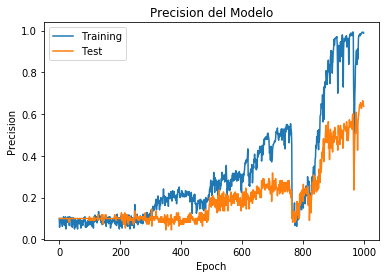

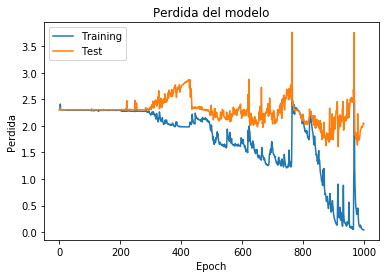

In [58]:
plot_and_saving(LSTMDD5,name='LSTM_Dropoutdelta5')

In [55]:
LSTMDD8=LSTM_with_Dropout('LSTM_Dropoutdelta08',dropout=0.8)

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 9s 38ms/step - loss: 2.3046 - acc: 0.0792 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 2/500
130/240 [===============>..............] - ETA: 2s - loss: 2.3018 - acc: 0.0923

KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: 'Models/Model_LSTM_Dropoutdelta08/prec.png'

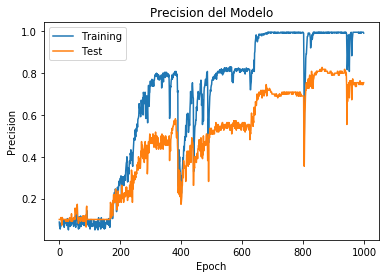

In [59]:
plot_and_saving(LSTMDD8,'LSTM_Dropoutdelta08')

In [47]:
LSTM_with_2layers_1D('LSTM_2Layer1DDelta5',dropout=0.5)

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 14s 59ms/step - loss: 2.3041 - acc: 0.0833 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 2/500
240/240 [==============================] - 14s 59ms/step - loss: 2.3037 - acc: 0.0958 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/500
240/240 [==============================] - 20s 85ms/step - loss: 2.3036 - acc: 0.1042 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 4/500
240/240 [==============================] - 18s 74ms/step - loss: 2.3040 - acc: 0.0750 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/500
240/240 [==============================] - 14s 57ms/step - loss: 2.3024 - acc: 0.0833 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/500
240/240 [==============================] - 15s 63ms/step - loss: 2.3019 - acc: 0.1042 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 7/500
240/240 [==============================] - 18s 76ms/step - loss: 2.2992 - acc: 0.1125 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 8/5

Epoch 61/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2943 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 62/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2939 - acc: 0.0833 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 63/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2942 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 64/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2939 - acc: 0.1250 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 65/500
240/240 [==============================] - 11s 46ms/step - loss: 2.2944 - acc: 0.1042 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 66/500
240/240 [==============================] - 11s 46ms/step - loss: 2.2940 - acc: 0.1083 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 67/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2943 - acc: 0.0917 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 68/500
240/240 [==========================

240/240 [==============================] - 11s 48ms/step - loss: 2.2971 - acc: 0.1250 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 122/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2973 - acc: 0.0917 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 123/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2947 - acc: 0.1042 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 124/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2933 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 125/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2930 - acc: 0.1542 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 126/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2953 - acc: 0.0917 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 127/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2935 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 128/500
240/240 [==============================] 

Epoch 181/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2934 - acc: 0.0917 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 182/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2923 - acc: 0.0917 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 183/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2946 - acc: 0.1167 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 184/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2952 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 185/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2928 - acc: 0.1167 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 186/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2923 - acc: 0.1125 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 187/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2944 - acc: 0.1292 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 188/500
240/240 [==================

Epoch 241/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2942 - acc: 0.0958 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 242/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2933 - acc: 0.0958 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 243/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2934 - acc: 0.1208 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 244/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2934 - acc: 0.0875 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 245/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2946 - acc: 0.1083 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 246/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2937 - acc: 0.1208 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 247/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2943 - acc: 0.1000 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 248/500
240/240 [==================

Epoch 301/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2935 - acc: 0.1167 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 302/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2937 - acc: 0.0875 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 303/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2941 - acc: 0.1042 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 304/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2946 - acc: 0.0792 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 305/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2939 - acc: 0.0708 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 306/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2935 - acc: 0.1208 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 307/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2935 - acc: 0.0917 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 308/500
240/240 [==================

Epoch 361/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2946 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 362/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2924 - acc: 0.1333 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 363/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2929 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 364/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2933 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 365/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2929 - acc: 0.1083 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 366/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2938 - acc: 0.1167 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 367/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2944 - acc: 0.1125 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 368/500
240/240 [==================

Epoch 421/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2942 - acc: 0.1042 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 422/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2927 - acc: 0.1208 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 423/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2931 - acc: 0.1125 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 424/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2934 - acc: 0.0792 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 425/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2932 - acc: 0.1042 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 426/500
240/240 [==============================] - 12s 48ms/step - loss: 2.2941 - acc: 0.1042 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 427/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2929 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 428/500
240/240 [==================

Epoch 481/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2934 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 482/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2931 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 483/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2959 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 484/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2922 - acc: 0.1250 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 485/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2922 - acc: 0.1167 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 486/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2925 - acc: 0.1125 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 487/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2934 - acc: 0.0958 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 488/500
240/240 [==================

In [48]:
LSTM_with_2layers_1D('LSTM_2Layer1DDelta8',dropout=0.8)

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 13s 55ms/step - loss: 2.3044 - acc: 0.0667 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/500
240/240 [==============================] - 11s 48ms/step - loss: 2.3025 - acc: 0.1167 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 3/500
240/240 [==============================] - 12s 48ms/step - loss: 2.3039 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 4/500
240/240 [==============================] - 12s 48ms/step - loss: 2.3037 - acc: 0.1083 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 5/500
240/240 [==============================] - 12s 48ms/step - loss: 2.3036 - acc: 0.0833 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 6/500
240/240 [==============================] - 12s 48ms/step - loss: 2.3024 - acc: 0.1208 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 7/500
240/240 [==============================] - 12s 48ms/step - loss: 2.3041 - acc: 0.1083 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 8/5

Epoch 61/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2931 - acc: 0.1167 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 62/500
240/240 [==============================] - 12s 48ms/step - loss: 2.2939 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 63/500
240/240 [==============================] - 11s 47ms/step - loss: 2.3049 - acc: 0.0708 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 64/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2999 - acc: 0.0917 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 65/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2936 - acc: 0.1208 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 66/500
240/240 [==============================] - 11s 48ms/step - loss: 2.3020 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 67/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2943 - acc: 0.1125 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 68/500
240/240 [==========================

240/240 [==============================] - 11s 47ms/step - loss: 2.2963 - acc: 0.0917 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 122/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2960 - acc: 0.1208 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 123/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2921 - acc: 0.1167 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 124/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2941 - acc: 0.1125 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 125/500
240/240 [==============================] - 12s 48ms/step - loss: 2.2887 - acc: 0.1417 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 126/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2972 - acc: 0.0792 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 127/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2931 - acc: 0.0958 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 128/500
240/240 [==============================] 

Epoch 181/500
240/240 [==============================] - 12s 48ms/step - loss: 2.2853 - acc: 0.1042 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 182/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2844 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 183/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2869 - acc: 0.1042 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 184/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2890 - acc: 0.0875 - val_loss: 2.3030 - val_acc: 0.1000
Epoch 185/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2827 - acc: 0.1000 - val_loss: 2.3032 - val_acc: 0.1000
Epoch 186/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2902 - acc: 0.0875 - val_loss: 2.3033 - val_acc: 0.1000
Epoch 187/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2894 - acc: 0.0958 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 188/500
240/240 [==================

Epoch 241/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2927 - acc: 0.1125 - val_loss: 2.3018 - val_acc: 0.0909
Epoch 242/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2756 - acc: 0.1042 - val_loss: 2.3014 - val_acc: 0.0909
Epoch 243/500
240/240 [==============================] - 11s 48ms/step - loss: 2.2803 - acc: 0.1125 - val_loss: 2.3013 - val_acc: 0.1182
Epoch 244/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2807 - acc: 0.1042 - val_loss: 2.3011 - val_acc: 0.1091
Epoch 245/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2669 - acc: 0.1167 - val_loss: 2.2966 - val_acc: 0.0636
Epoch 246/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2732 - acc: 0.1042 - val_loss: 2.2971 - val_acc: 0.1000
Epoch 247/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2772 - acc: 0.1500 - val_loss: 2.2988 - val_acc: 0.0818
Epoch 248/500
240/240 [==================

Epoch 301/500
240/240 [==============================] - 11s 47ms/step - loss: 1.9299 - acc: 0.2833 - val_loss: 2.4380 - val_acc: 0.1000
Epoch 302/500
240/240 [==============================] - 11s 47ms/step - loss: 1.9833 - acc: 0.2542 - val_loss: 2.4681 - val_acc: 0.1273
Epoch 303/500
240/240 [==============================] - 12s 48ms/step - loss: 1.9717 - acc: 0.2875 - val_loss: 2.5168 - val_acc: 0.1273
Epoch 304/500
240/240 [==============================] - 11s 47ms/step - loss: 1.9072 - acc: 0.2750 - val_loss: 2.4502 - val_acc: 0.0909
Epoch 305/500
240/240 [==============================] - 11s 47ms/step - loss: 1.8722 - acc: 0.2917 - val_loss: 2.5139 - val_acc: 0.1000
Epoch 306/500
240/240 [==============================] - 11s 47ms/step - loss: 1.9819 - acc: 0.2625 - val_loss: 2.5418 - val_acc: 0.0727
Epoch 307/500
240/240 [==============================] - 11s 47ms/step - loss: 1.9131 - acc: 0.3000 - val_loss: 2.5757 - val_acc: 0.1091
Epoch 308/500
240/240 [==================

Epoch 361/500
240/240 [==============================] - 11s 47ms/step - loss: 1.5734 - acc: 0.4042 - val_loss: 2.9206 - val_acc: 0.1091
Epoch 362/500
240/240 [==============================] - 11s 48ms/step - loss: 1.5608 - acc: 0.3917 - val_loss: 2.9435 - val_acc: 0.1636
Epoch 363/500
240/240 [==============================] - 11s 48ms/step - loss: 1.4686 - acc: 0.4083 - val_loss: 2.9890 - val_acc: 0.1727
Epoch 364/500
240/240 [==============================] - 11s 48ms/step - loss: 1.4882 - acc: 0.4708 - val_loss: 3.0268 - val_acc: 0.1455
Epoch 365/500
240/240 [==============================] - 11s 47ms/step - loss: 1.5438 - acc: 0.4083 - val_loss: 3.1233 - val_acc: 0.1091
Epoch 366/500
240/240 [==============================] - 12s 48ms/step - loss: 1.4923 - acc: 0.4000 - val_loss: 3.1130 - val_acc: 0.1182
Epoch 367/500
240/240 [==============================] - 11s 47ms/step - loss: 1.4718 - acc: 0.4708 - val_loss: 3.1565 - val_acc: 0.1000
Epoch 368/500
240/240 [==================

Epoch 421/500
240/240 [==============================] - 11s 47ms/step - loss: 1.2107 - acc: 0.5125 - val_loss: 4.1469 - val_acc: 0.1091
Epoch 422/500
240/240 [==============================] - 11s 47ms/step - loss: 1.1678 - acc: 0.5250 - val_loss: 4.0886 - val_acc: 0.1455
Epoch 423/500
240/240 [==============================] - 11s 47ms/step - loss: 1.1937 - acc: 0.5458 - val_loss: 4.2088 - val_acc: 0.1273
Epoch 424/500
240/240 [==============================] - 11s 47ms/step - loss: 1.2111 - acc: 0.5083 - val_loss: 4.2246 - val_acc: 0.1182
Epoch 425/500
240/240 [==============================] - 11s 47ms/step - loss: 1.2017 - acc: 0.5250 - val_loss: 4.2516 - val_acc: 0.1455
Epoch 426/500
240/240 [==============================] - 11s 48ms/step - loss: 1.2054 - acc: 0.5083 - val_loss: 4.1317 - val_acc: 0.1182
Epoch 427/500
240/240 [==============================] - 11s 47ms/step - loss: 1.0880 - acc: 0.5625 - val_loss: 4.2997 - val_acc: 0.1273
Epoch 428/500
240/240 [==================

Epoch 481/500
240/240 [==============================] - 12s 48ms/step - loss: 1.1408 - acc: 0.6000 - val_loss: 4.5937 - val_acc: 0.1091
Epoch 482/500
240/240 [==============================] - 11s 48ms/step - loss: 1.1149 - acc: 0.5375 - val_loss: 4.5408 - val_acc: 0.1545
Epoch 483/500
240/240 [==============================] - 11s 47ms/step - loss: 1.2273 - acc: 0.5292 - val_loss: 4.7546 - val_acc: 0.1091
Epoch 484/500
240/240 [==============================] - 11s 48ms/step - loss: 1.1140 - acc: 0.5542 - val_loss: 4.6849 - val_acc: 0.1273
Epoch 485/500
240/240 [==============================] - 11s 47ms/step - loss: 1.0051 - acc: 0.5708 - val_loss: 4.8579 - val_acc: 0.1182
Epoch 486/500
240/240 [==============================] - 11s 47ms/step - loss: 1.0274 - acc: 0.6042 - val_loss: 4.9194 - val_acc: 0.1182
Epoch 487/500
240/240 [==============================] - 11s 48ms/step - loss: 0.9577 - acc: 0.6083 - val_loss: 4.8453 - val_acc: 0.1545
Epoch 488/500
240/240 [==================

In [51]:
LSTMDD5=LSTM_with_Dropout('LSTM_Dropoutdelta5',dropout=0.5,n_epochs=1000)

Train on 240 samples, validate on 110 samples
Epoch 1/1000
240/240 [==============================] - 12s 49ms/step - loss: 2.3052 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/1000
240/240 [==============================] - 9s 39ms/step - loss: 2.3037 - acc: 0.0583 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/1000
240/240 [==============================] - 10s 40ms/step - loss: 2.3029 - acc: 0.0833 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/1000
240/240 [==============================] - 10s 42ms/step - loss: 2.4110 - acc: 0.1000 - val_loss: 2.3320 - val_acc: 0.1000
Epoch 5/1000
240/240 [==============================] - 10s 41ms/step - loss: 2.3087 - acc: 0.0833 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 6/1000
240/240 [==============================] - 10s 40ms/step - loss: 2.3026 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 7/1000
240/240 [==============================] - 9s 39ms/step - loss: 2.3025 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.1000
Epoc

Epoch 61/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2940 - acc: 0.0500 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 62/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2941 - acc: 0.0833 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 63/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2941 - acc: 0.0958 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 64/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2940 - acc: 0.0792 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 65/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2938 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 66/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2946 - acc: 0.0750 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 67/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2936 - acc: 0.0792 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 68/1000
240/240 [=========================

240/240 [==============================] - 5s 23ms/step - loss: 2.2934 - acc: 0.0875 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 122/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2933 - acc: 0.1083 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 123/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2941 - acc: 0.0917 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 124/1000
240/240 [==============================] - 8s 32ms/step - loss: 2.2926 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 125/1000
240/240 [==============================] - 10s 44ms/step - loss: 2.2916 - acc: 0.0792 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 126/1000
240/240 [==============================] - 9s 39ms/step - loss: 2.2902 - acc: 0.1042 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 127/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.2866 - acc: 0.1125 - val_loss: 2.3059 - val_acc: 0.1091
Epoch 128/1000
240/240 [==============================]

Epoch 181/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2929 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 182/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2933 - acc: 0.1083 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 183/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.2943 - acc: 0.1083 - val_loss: 2.3026 - val_acc: 0.1182
Epoch 184/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2936 - acc: 0.0750 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 185/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2928 - acc: 0.0958 - val_loss: 2.3025 - val_acc: 0.1000
Epoch 186/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2926 - acc: 0.0708 - val_loss: 2.3025 - val_acc: 0.1091
Epoch 187/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.2914 - acc: 0.1125 - val_loss: 2.3019 - val_acc: 0.1091
Epoch 188/1000
240/240 [=================

Epoch 241/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.2746 - acc: 0.1042 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 242/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.2746 - acc: 0.0958 - val_loss: 2.3028 - val_acc: 0.0909
Epoch 243/1000
240/240 [==============================] - 9s 38ms/step - loss: 2.2745 - acc: 0.0792 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 244/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2747 - acc: 0.0750 - val_loss: 2.3029 - val_acc: 0.0727
Epoch 245/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.2751 - acc: 0.0875 - val_loss: 2.3032 - val_acc: 0.0909
Epoch 246/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2745 - acc: 0.0542 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 247/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.2739 - acc: 0.0833 - val_loss: 2.3031 - val_acc: 0.0818
Epoch 248/1000
240/240 [=================

Epoch 301/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.2018 - acc: 0.1375 - val_loss: 2.3459 - val_acc: 0.0909
Epoch 302/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2118 - acc: 0.1292 - val_loss: 2.3052 - val_acc: 0.1000
Epoch 303/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.2233 - acc: 0.1417 - val_loss: 2.3342 - val_acc: 0.1000
Epoch 304/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2487 - acc: 0.1333 - val_loss: 2.3983 - val_acc: 0.1455
Epoch 305/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2617 - acc: 0.1083 - val_loss: 2.3805 - val_acc: 0.0636
Epoch 306/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2314 - acc: 0.1250 - val_loss: 2.3677 - val_acc: 0.1000
Epoch 307/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.2283 - acc: 0.1333 - val_loss: 2.3592 - val_acc: 0.1091
Epoch 308/1000
240/240 [=================

Epoch 361/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.0221 - acc: 0.2042 - val_loss: 2.6748 - val_acc: 0.0818
Epoch 362/1000
240/240 [==============================] - 9s 38ms/step - loss: 2.0238 - acc: 0.1958 - val_loss: 2.6088 - val_acc: 0.1000
Epoch 363/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.0230 - acc: 0.1958 - val_loss: 2.6081 - val_acc: 0.1000
Epoch 364/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.0168 - acc: 0.2042 - val_loss: 2.6250 - val_acc: 0.0727
Epoch 365/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.0299 - acc: 0.2167 - val_loss: 2.5836 - val_acc: 0.0727
Epoch 366/1000
240/240 [==============================] - 9s 37ms/step - loss: 2.0127 - acc: 0.1958 - val_loss: 2.5966 - val_acc: 0.0727
Epoch 367/1000
240/240 [==============================] - 9s 36ms/step - loss: 2.0221 - acc: 0.2292 - val_loss: 2.5512 - val_acc: 0.0909
Epoch 368/1000
240/240 [=================

Epoch 421/1000
240/240 [==============================] - 6s 24ms/step - loss: 1.9816 - acc: 0.2250 - val_loss: 2.8379 - val_acc: 0.0818
Epoch 422/1000
240/240 [==============================] - 7s 27ms/step - loss: 1.9810 - acc: 0.2167 - val_loss: 2.8488 - val_acc: 0.1000
Epoch 423/1000
240/240 [==============================] - 6s 27ms/step - loss: 1.9808 - acc: 0.2125 - val_loss: 2.8538 - val_acc: 0.1091
Epoch 424/1000
240/240 [==============================] - 7s 31ms/step - loss: 1.9809 - acc: 0.2167 - val_loss: 2.8563 - val_acc: 0.0818
Epoch 425/1000
240/240 [==============================] - 7s 27ms/step - loss: 1.9809 - acc: 0.2125 - val_loss: 2.8721 - val_acc: 0.1182
Epoch 426/1000
240/240 [==============================] - 8s 32ms/step - loss: 1.9801 - acc: 0.2250 - val_loss: 2.8701 - val_acc: 0.1091
Epoch 427/1000
240/240 [==============================] - 7s 30ms/step - loss: 1.9805 - acc: 0.2292 - val_loss: 2.8600 - val_acc: 0.1000
Epoch 428/1000
240/240 [=================

Epoch 481/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.1188 - acc: 0.1458 - val_loss: 2.2970 - val_acc: 0.1455
Epoch 482/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.1166 - acc: 0.2000 - val_loss: 2.3109 - val_acc: 0.0909
Epoch 483/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.1290 - acc: 0.1833 - val_loss: 2.2996 - val_acc: 0.1091
Epoch 484/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.1129 - acc: 0.1875 - val_loss: 2.2913 - val_acc: 0.1091
Epoch 485/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.1263 - acc: 0.1875 - val_loss: 2.2991 - val_acc: 0.0818
Epoch 486/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.0912 - acc: 0.1792 - val_loss: 2.2851 - val_acc: 0.1000
Epoch 487/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.0919 - acc: 0.1875 - val_loss: 2.2903 - val_acc: 0.1364
Epoch 488/1000
240/240 [=================

Epoch 541/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6275 - acc: 0.3083 - val_loss: 2.1739 - val_acc: 0.1818
Epoch 542/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6063 - acc: 0.2875 - val_loss: 2.1657 - val_acc: 0.2000
Epoch 543/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.6559 - acc: 0.2917 - val_loss: 2.1670 - val_acc: 0.1364
Epoch 544/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.6471 - acc: 0.2750 - val_loss: 2.1461 - val_acc: 0.1727
Epoch 545/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.6211 - acc: 0.2875 - val_loss: 2.1493 - val_acc: 0.1636
Epoch 546/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6064 - acc: 0.3125 - val_loss: 2.1476 - val_acc: 0.1909
Epoch 547/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6206 - acc: 0.3083 - val_loss: 2.1473 - val_acc: 0.1818
Epoch 548/1000
240/240 [=================

Epoch 601/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6831 - acc: 0.2792 - val_loss: 2.2143 - val_acc: 0.1909
Epoch 602/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6640 - acc: 0.3125 - val_loss: 2.1808 - val_acc: 0.2273
Epoch 603/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6948 - acc: 0.2750 - val_loss: 2.2980 - val_acc: 0.2273
Epoch 604/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.7413 - acc: 0.2792 - val_loss: 2.2058 - val_acc: 0.1545
Epoch 605/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6728 - acc: 0.2875 - val_loss: 2.2148 - val_acc: 0.2000
Epoch 606/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6529 - acc: 0.3125 - val_loss: 2.3070 - val_acc: 0.1818
Epoch 607/1000
240/240 [==============================] - 6s 23ms/step - loss: 1.6474 - acc: 0.3083 - val_loss: 2.2411 - val_acc: 0.2091
Epoch 608/1000
240/240 [=================

Epoch 661/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.3719 - acc: 0.4375 - val_loss: 2.1148 - val_acc: 0.2000
Epoch 662/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.3643 - acc: 0.4250 - val_loss: 2.3375 - val_acc: 0.2091
Epoch 663/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.3754 - acc: 0.4292 - val_loss: 2.2545 - val_acc: 0.2364
Epoch 664/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.3569 - acc: 0.4458 - val_loss: 2.7266 - val_acc: 0.2000
Epoch 665/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.5915 - acc: 0.3750 - val_loss: 2.2844 - val_acc: 0.2818
Epoch 666/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.5925 - acc: 0.4208 - val_loss: 2.1420 - val_acc: 0.2545
Epoch 667/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.4709 - acc: 0.4167 - val_loss: 2.0404 - val_acc: 0.2455
Epoch 668/1000
240/240 [=================

Epoch 721/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.4095 - acc: 0.4750 - val_loss: 2.2498 - val_acc: 0.2455
Epoch 722/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.3092 - acc: 0.5000 - val_loss: 2.2597 - val_acc: 0.2636
Epoch 723/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.3074 - acc: 0.4917 - val_loss: 2.2692 - val_acc: 0.2545
Epoch 724/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.3484 - acc: 0.4917 - val_loss: 2.3874 - val_acc: 0.2182
Epoch 725/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.2840 - acc: 0.5042 - val_loss: 2.3616 - val_acc: 0.2455
Epoch 726/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.2791 - acc: 0.5083 - val_loss: 2.2303 - val_acc: 0.2818
Epoch 727/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.2581 - acc: 0.4958 - val_loss: 2.4251 - val_acc: 0.2273
Epoch 728/1000
240/240 [=================

Epoch 781/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3159 - acc: 0.0750 - val_loss: 2.2931 - val_acc: 0.1818
Epoch 782/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3095 - acc: 0.1167 - val_loss: 2.2912 - val_acc: 0.1364
Epoch 783/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3010 - acc: 0.0917 - val_loss: 2.2865 - val_acc: 0.1182
Epoch 784/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.2995 - acc: 0.1083 - val_loss: 2.2864 - val_acc: 0.1727
Epoch 785/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.2962 - acc: 0.1375 - val_loss: 2.2821 - val_acc: 0.1182
Epoch 786/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2904 - acc: 0.0958 - val_loss: 2.2791 - val_acc: 0.1273
Epoch 787/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2772 - acc: 0.1375 - val_loss: 2.2725 - val_acc: 0.1182
Epoch 788/1000
240/240 [=================

Epoch 841/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.6092 - acc: 0.3875 - val_loss: 1.9617 - val_acc: 0.2909
Epoch 842/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.5591 - acc: 0.3917 - val_loss: 2.0832 - val_acc: 0.2727
Epoch 843/1000
240/240 [==============================] - 6s 23ms/step - loss: 1.5232 - acc: 0.4500 - val_loss: 1.9619 - val_acc: 0.2818
Epoch 844/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.4473 - acc: 0.4375 - val_loss: 1.9902 - val_acc: 0.2727
Epoch 845/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.4638 - acc: 0.4458 - val_loss: 2.1233 - val_acc: 0.2273
Epoch 846/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.4207 - acc: 0.4917 - val_loss: 2.0538 - val_acc: 0.2636
Epoch 847/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.3327 - acc: 0.4917 - val_loss: 2.1075 - val_acc: 0.2364
Epoch 848/1000
240/240 [=================

Epoch 901/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.3429 - acc: 0.9083 - val_loss: 1.8705 - val_acc: 0.5182
Epoch 902/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.2902 - acc: 0.9375 - val_loss: 1.9672 - val_acc: 0.4636
Epoch 903/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.2609 - acc: 0.9583 - val_loss: 2.1657 - val_acc: 0.4909
Epoch 904/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.2422 - acc: 0.9292 - val_loss: 2.0291 - val_acc: 0.4909
Epoch 905/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.2362 - acc: 0.9417 - val_loss: 1.9413 - val_acc: 0.5364
Epoch 906/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.2034 - acc: 0.9625 - val_loss: 2.0722 - val_acc: 0.5182
Epoch 907/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.1845 - acc: 0.9625 - val_loss: 2.0322 - val_acc: 0.5182
Epoch 908/1000
240/240 [=================

Epoch 961/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.0767 - acc: 0.9833 - val_loss: 2.4907 - val_acc: 0.5455
Epoch 962/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.0973 - acc: 0.9750 - val_loss: 2.5189 - val_acc: 0.5273
Epoch 963/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.0596 - acc: 0.9917 - val_loss: 2.4452 - val_acc: 0.5818
Epoch 964/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.0533 - acc: 0.9917 - val_loss: 2.4469 - val_acc: 0.6000
Epoch 965/1000
240/240 [==============================] - 6s 23ms/step - loss: 0.0561 - acc: 0.9875 - val_loss: 2.4644 - val_acc: 0.6000
Epoch 966/1000
240/240 [==============================] - 6s 23ms/step - loss: 0.0512 - acc: 0.9917 - val_loss: 2.6837 - val_acc: 0.5455
Epoch 967/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.0170 - acc: 0.7375 - val_loss: 2.5948 - val_acc: 0.3909
Epoch 968/1000
240/240 [=================

In [52]:
LSTMDD8=LSTM_with_Dropout('LSTM_Dropoutdelta8',dropout=0.8,n_epochs=1000)

Train on 240 samples, validate on 110 samples
Epoch 1/1000
240/240 [==============================] - 7s 30ms/step - loss: 2.3051 - acc: 0.0875 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3038 - acc: 0.0667 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3032 - acc: 0.0667 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3008 - acc: 0.0542 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3042 - acc: 0.0667 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2999 - acc: 0.0667 - val_loss: 2.3031 - val_acc: 0.1091
Epoch 7/1000
240/240 [==============================] - 6s 23ms/step - loss: 2.3019 - acc: 0.0833 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 8/1

Epoch 61/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.2987 - acc: 0.0750 - val_loss: 2.3082 - val_acc: 0.1091
Epoch 62/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.3096 - acc: 0.0917 - val_loss: 2.3140 - val_acc: 0.1000
Epoch 63/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3160 - acc: 0.0792 - val_loss: 2.3147 - val_acc: 0.1000
Epoch 64/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3129 - acc: 0.0542 - val_loss: 2.3131 - val_acc: 0.0818
Epoch 65/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3141 - acc: 0.0708 - val_loss: 2.3143 - val_acc: 0.1000
Epoch 66/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3038 - acc: 0.1125 - val_loss: 2.3147 - val_acc: 0.1091
Epoch 67/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3059 - acc: 0.0583 - val_loss: 2.3126 - val_acc: 0.1000
Epoch 68/1000
240/240 [=========================

240/240 [==============================] - 5s 23ms/step - loss: 2.3141 - acc: 0.0583 - val_loss: 2.3033 - val_acc: 0.1000
Epoch 122/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.3103 - acc: 0.0875 - val_loss: 2.3034 - val_acc: 0.1000
Epoch 123/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3174 - acc: 0.0875 - val_loss: 2.3045 - val_acc: 0.1000
Epoch 124/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3157 - acc: 0.0792 - val_loss: 2.3040 - val_acc: 0.1000
Epoch 125/1000
240/240 [==============================] - 5s 23ms/step - loss: 2.3176 - acc: 0.0708 - val_loss: 2.3037 - val_acc: 0.1000
Epoch 126/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.3161 - acc: 0.0875 - val_loss: 2.3038 - val_acc: 0.1000
Epoch 127/1000
240/240 [==============================] - 5s 22ms/step - loss: 2.3093 - acc: 0.0958 - val_loss: 2.3035 - val_acc: 0.1000
Epoch 128/1000
240/240 [==============================] 

Epoch 181/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.9645 - acc: 0.2125 - val_loss: 2.0042 - val_acc: 0.2182
Epoch 182/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.9327 - acc: 0.2292 - val_loss: 1.9970 - val_acc: 0.2091
Epoch 183/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.9057 - acc: 0.2042 - val_loss: 2.0361 - val_acc: 0.1818
Epoch 184/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.9129 - acc: 0.2292 - val_loss: 1.9954 - val_acc: 0.1818
Epoch 185/1000
240/240 [==============================] - 6s 23ms/step - loss: 1.8754 - acc: 0.2458 - val_loss: 2.0088 - val_acc: 0.2091
Epoch 186/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.8418 - acc: 0.2375 - val_loss: 1.9083 - val_acc: 0.2455
Epoch 187/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.8721 - acc: 0.2375 - val_loss: 1.9664 - val_acc: 0.2000
Epoch 188/1000
240/240 [=================

Epoch 241/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.8884 - acc: 0.3625 - val_loss: 2.3635 - val_acc: 0.1818
Epoch 242/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.6043 - acc: 0.3542 - val_loss: 1.8597 - val_acc: 0.2727
Epoch 243/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.4537 - acc: 0.3958 - val_loss: 1.7899 - val_acc: 0.2455
Epoch 244/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.3995 - acc: 0.4333 - val_loss: 1.8112 - val_acc: 0.3000
Epoch 245/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.3583 - acc: 0.4625 - val_loss: 1.7952 - val_acc: 0.2727
Epoch 246/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.3441 - acc: 0.4875 - val_loss: 1.8313 - val_acc: 0.3091
Epoch 247/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.3312 - acc: 0.4833 - val_loss: 1.7856 - val_acc: 0.2909
Epoch 248/1000
240/240 [=================

Epoch 301/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.7083 - acc: 0.7375 - val_loss: 1.5519 - val_acc: 0.4727
Epoch 302/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.7017 - acc: 0.7500 - val_loss: 1.5308 - val_acc: 0.4636
Epoch 303/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.7159 - acc: 0.7542 - val_loss: 1.5349 - val_acc: 0.4909
Epoch 304/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.7087 - acc: 0.7458 - val_loss: 1.5807 - val_acc: 0.4818
Epoch 305/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.6877 - acc: 0.7708 - val_loss: 1.5648 - val_acc: 0.4818
Epoch 306/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.7028 - acc: 0.7500 - val_loss: 1.5541 - val_acc: 0.4909
Epoch 307/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.6860 - acc: 0.7375 - val_loss: 1.5692 - val_acc: 0.4636
Epoch 308/1000
240/240 [=================

Epoch 361/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.5364 - acc: 0.7917 - val_loss: 1.9489 - val_acc: 0.4727
Epoch 362/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.7553 - acc: 0.7292 - val_loss: 1.7924 - val_acc: 0.5000
Epoch 363/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.2040 - acc: 0.5833 - val_loss: 2.0393 - val_acc: 0.3818
Epoch 364/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.0361 - acc: 0.6000 - val_loss: 1.9381 - val_acc: 0.4545
Epoch 365/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.8496 - acc: 0.7042 - val_loss: 1.8501 - val_acc: 0.4636
Epoch 366/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.7763 - acc: 0.7375 - val_loss: 1.7737 - val_acc: 0.4273
Epoch 367/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.8135 - acc: 0.7333 - val_loss: 1.6639 - val_acc: 0.4818
Epoch 368/1000
240/240 [=================

Epoch 421/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.3047 - acc: 0.5792 - val_loss: 1.6761 - val_acc: 0.4273
Epoch 422/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.1823 - acc: 0.6042 - val_loss: 1.6571 - val_acc: 0.4091
Epoch 423/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.1460 - acc: 0.6083 - val_loss: 1.6255 - val_acc: 0.4182
Epoch 424/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.1483 - acc: 0.5917 - val_loss: 1.8097 - val_acc: 0.3545
Epoch 425/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.2672 - acc: 0.5167 - val_loss: 1.5283 - val_acc: 0.4273
Epoch 426/1000
240/240 [==============================] - 5s 22ms/step - loss: 1.2421 - acc: 0.5375 - val_loss: 1.7206 - val_acc: 0.3727
Epoch 427/1000
240/240 [==============================] - 5s 23ms/step - loss: 1.2216 - acc: 0.5750 - val_loss: 1.7585 - val_acc: 0.3636
Epoch 428/1000
240/240 [=================

Epoch 481/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.6418 - acc: 0.7708 - val_loss: 1.7594 - val_acc: 0.4545
Epoch 482/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.6647 - acc: 0.7625 - val_loss: 1.7984 - val_acc: 0.4545
Epoch 483/1000
240/240 [==============================] - 6s 23ms/step - loss: 0.6664 - acc: 0.7417 - val_loss: 1.4748 - val_acc: 0.5000
Epoch 484/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.6159 - acc: 0.7667 - val_loss: 1.4507 - val_acc: 0.5091
Epoch 485/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.5957 - acc: 0.8000 - val_loss: 1.6227 - val_acc: 0.5091
Epoch 486/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.5879 - acc: 0.7833 - val_loss: 1.6294 - val_acc: 0.5000
Epoch 487/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.5716 - acc: 0.8083 - val_loss: 1.5040 - val_acc: 0.4818
Epoch 488/1000
240/240 [=================

Epoch 541/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.5034 - acc: 0.8167 - val_loss: 1.5340 - val_acc: 0.5273
Epoch 542/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4978 - acc: 0.8167 - val_loss: 1.5424 - val_acc: 0.5455
Epoch 543/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4897 - acc: 0.8250 - val_loss: 1.5923 - val_acc: 0.5455
Epoch 544/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4905 - acc: 0.8083 - val_loss: 1.5935 - val_acc: 0.5455
Epoch 545/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4862 - acc: 0.8250 - val_loss: 1.5958 - val_acc: 0.5545
Epoch 546/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4824 - acc: 0.8208 - val_loss: 1.5896 - val_acc: 0.5545
Epoch 547/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4804 - acc: 0.8167 - val_loss: 1.6012 - val_acc: 0.5545
Epoch 548/1000
240/240 [=================

Epoch 601/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4661 - acc: 0.8125 - val_loss: 1.6836 - val_acc: 0.5455
Epoch 602/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4672 - acc: 0.8208 - val_loss: 1.6585 - val_acc: 0.5636
Epoch 603/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4669 - acc: 0.8208 - val_loss: 1.6569 - val_acc: 0.5455
Epoch 604/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.4664 - acc: 0.8125 - val_loss: 1.7070 - val_acc: 0.5455
Epoch 605/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.4660 - acc: 0.8125 - val_loss: 1.6949 - val_acc: 0.5545
Epoch 606/1000
240/240 [==============================] - 6s 23ms/step - loss: 0.4663 - acc: 0.8083 - val_loss: 1.7271 - val_acc: 0.5273
Epoch 607/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.4656 - acc: 0.8083 - val_loss: 1.7030 - val_acc: 0.5636
Epoch 608/1000
240/240 [=================

Epoch 661/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.0610 - acc: 0.9833 - val_loss: 1.1996 - val_acc: 0.7000
Epoch 662/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.0579 - acc: 0.9833 - val_loss: 1.2168 - val_acc: 0.7091
Epoch 663/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.0552 - acc: 0.9875 - val_loss: 1.2183 - val_acc: 0.7182
Epoch 664/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.0524 - acc: 0.9833 - val_loss: 1.2398 - val_acc: 0.7000
Epoch 665/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.0762 - acc: 0.9792 - val_loss: 1.2896 - val_acc: 0.7091
Epoch 666/1000
240/240 [==============================] - 5s 22ms/step - loss: 0.0841 - acc: 0.9792 - val_loss: 1.1804 - val_acc: 0.6818
Epoch 667/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.0615 - acc: 0.9875 - val_loss: 1.2272 - val_acc: 0.6818
Epoch 668/1000
240/240 [=================

Epoch 721/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.0089 - acc: 0.9958 - val_loss: 1.3766 - val_acc: 0.6909
Epoch 722/1000
240/240 [==============================] - 6s 24ms/step - loss: 0.0091 - acc: 0.9917 - val_loss: 1.3746 - val_acc: 0.6909
Epoch 723/1000
240/240 [==============================] - 6s 23ms/step - loss: 0.0094 - acc: 0.9917 - val_loss: 1.3799 - val_acc: 0.7000
Epoch 724/1000
240/240 [==============================] - 6s 23ms/step - loss: 0.0091 - acc: 0.9917 - val_loss: 1.3819 - val_acc: 0.6909
Epoch 725/1000
240/240 [==============================] - 5s 23ms/step - loss: 0.0093 - acc: 0.9917 - val_loss: 1.3869 - val_acc: 0.7000
Epoch 726/1000
240/240 [==============================] - 6s 23ms/step - loss: 0.0092 - acc: 0.9917 - val_loss: 1.3938 - val_acc: 0.6909
Epoch 727/1000
240/240 [==============================] - 6s 23ms/step - loss: 0.0090 - acc: 0.9958 - val_loss: 1.4013 - val_acc: 0.6909
Epoch 728/1000
240/240 [=================

Epoch 781/1000
240/240 [==============================] - 9s 37ms/step - loss: 0.0073 - acc: 0.9958 - val_loss: 1.5343 - val_acc: 0.7000
Epoch 782/1000
240/240 [==============================] - 9s 38ms/step - loss: 0.0072 - acc: 0.9917 - val_loss: 1.5402 - val_acc: 0.7091
Epoch 783/1000
240/240 [==============================] - 9s 37ms/step - loss: 0.0077 - acc: 0.9917 - val_loss: 1.5340 - val_acc: 0.7091
Epoch 784/1000
240/240 [==============================] - 9s 37ms/step - loss: 0.0078 - acc: 0.9958 - val_loss: 1.5431 - val_acc: 0.7091
Epoch 785/1000
240/240 [==============================] - 9s 36ms/step - loss: 0.0071 - acc: 0.9958 - val_loss: 1.5224 - val_acc: 0.6909
Epoch 786/1000
240/240 [==============================] - 9s 37ms/step - loss: 0.0070 - acc: 0.9958 - val_loss: 1.5118 - val_acc: 0.7000
Epoch 787/1000
240/240 [==============================] - 9s 36ms/step - loss: 0.0078 - acc: 0.9917 - val_loss: 1.5204 - val_acc: 0.6909
Epoch 788/1000
240/240 [=================

Epoch 841/1000
240/240 [==============================] - 7s 30ms/step - loss: 0.0163 - acc: 0.9917 - val_loss: 0.8729 - val_acc: 0.8000
Epoch 842/1000
240/240 [==============================] - 7s 30ms/step - loss: 0.0150 - acc: 0.9917 - val_loss: 0.8771 - val_acc: 0.8000
Epoch 843/1000
240/240 [==============================] - 7s 30ms/step - loss: 0.0143 - acc: 0.9917 - val_loss: 0.8795 - val_acc: 0.7909
Epoch 844/1000
240/240 [==============================] - 8s 32ms/step - loss: 0.0145 - acc: 0.9958 - val_loss: 0.8723 - val_acc: 0.8000
Epoch 845/1000
240/240 [==============================] - 7s 29ms/step - loss: 0.0138 - acc: 0.9958 - val_loss: 0.8350 - val_acc: 0.8091
Epoch 846/1000
240/240 [==============================] - 7s 30ms/step - loss: 0.0138 - acc: 0.9917 - val_loss: 0.8448 - val_acc: 0.8000
Epoch 847/1000
240/240 [==============================] - 7s 30ms/step - loss: 0.0137 - acc: 0.9917 - val_loss: 0.8453 - val_acc: 0.8091
Epoch 848/1000
240/240 [=================

Epoch 901/1000
240/240 [==============================] - 8s 34ms/step - loss: 0.0081 - acc: 0.9958 - val_loss: 0.9245 - val_acc: 0.7909
Epoch 902/1000
240/240 [==============================] - 9s 36ms/step - loss: 0.0076 - acc: 0.9958 - val_loss: 0.9175 - val_acc: 0.7909
Epoch 903/1000
240/240 [==============================] - 8s 35ms/step - loss: 0.0082 - acc: 0.9917 - val_loss: 0.9354 - val_acc: 0.7909
Epoch 904/1000
240/240 [==============================] - 8s 35ms/step - loss: 0.0078 - acc: 0.9917 - val_loss: 0.9371 - val_acc: 0.7909
Epoch 905/1000
240/240 [==============================] - 8s 34ms/step - loss: 0.0075 - acc: 0.9958 - val_loss: 0.9244 - val_acc: 0.8000
Epoch 906/1000
240/240 [==============================] - 9s 36ms/step - loss: 0.0072 - acc: 0.9958 - val_loss: 0.9393 - val_acc: 0.8000
Epoch 907/1000
240/240 [==============================] - 9s 37ms/step - loss: 0.0077 - acc: 0.9958 - val_loss: 0.9537 - val_acc: 0.8000
Epoch 908/1000
240/240 [=================

Epoch 961/1000
240/240 [==============================] - 9s 36ms/step - loss: 0.4382 - acc: 0.8833 - val_loss: 1.2931 - val_acc: 0.6727
Epoch 962/1000
240/240 [==============================] - 9s 36ms/step - loss: 0.2471 - acc: 0.9292 - val_loss: 1.0977 - val_acc: 0.7273
Epoch 963/1000
240/240 [==============================] - 9s 36ms/step - loss: 0.1006 - acc: 0.9667 - val_loss: 1.0965 - val_acc: 0.7545
Epoch 964/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0773 - acc: 0.9792 - val_loss: 1.0528 - val_acc: 0.7727
Epoch 965/1000
240/240 [==============================] - 9s 38ms/step - loss: 0.0332 - acc: 0.9958 - val_loss: 1.0462 - val_acc: 0.7455
Epoch 966/1000
240/240 [==============================] - 9s 36ms/step - loss: 0.0274 - acc: 0.9958 - val_loss: 0.9895 - val_acc: 0.7455
Epoch 967/1000
240/240 [==============================] - 9s 37ms/step - loss: 0.0246 - acc: 0.9958 - val_loss: 1.0022 - val_acc: 0.7455
Epoch 968/1000
240/240 [================

In [54]:
LSTM_with_2layers_1D('LSTM_2Layer1DDelta5epochs1000',dropout=0.5,n_epochs=1000)

Train on 240 samples, validate on 110 samples
Epoch 1/1000
240/240 [==============================] - 16s 65ms/step - loss: 2.3038 - acc: 0.0833 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 2/1000
240/240 [==============================] - 12s 51ms/step - loss: 2.3041 - acc: 0.0958 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 3/1000
240/240 [==============================] - 12s 50ms/step - loss: 2.3031 - acc: 0.1208 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/1000
240/240 [==============================] - 12s 51ms/step - loss: 2.3036 - acc: 0.1042 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 5/1000
240/240 [==============================] - 12s 51ms/step - loss: 2.3025 - acc: 0.0917 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 6/1000
240/240 [==============================] - 12s 51ms/step - loss: 2.3037 - acc: 0.0917 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/1000
240/240 [==============================] - 12s 50ms/step - loss: 2.3028 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.1000
Ep

240/240 [==============================] - 16s 65ms/step - loss: 2.2750 - acc: 0.1250 - val_loss: 2.3075 - val_acc: 0.1000
Epoch 61/1000
240/240 [==============================] - 13s 53ms/step - loss: 2.2731 - acc: 0.1292 - val_loss: 2.3094 - val_acc: 0.1273
Epoch 62/1000
240/240 [==============================] - 13s 55ms/step - loss: 2.2730 - acc: 0.1042 - val_loss: 2.3113 - val_acc: 0.1000
Epoch 63/1000
240/240 [==============================] - 14s 58ms/step - loss: 2.2589 - acc: 0.1167 - val_loss: 2.3083 - val_acc: 0.1182
Epoch 64/1000
240/240 [==============================] - 13s 53ms/step - loss: 2.2532 - acc: 0.1375 - val_loss: 2.3404 - val_acc: 0.0636
Epoch 65/1000
240/240 [==============================] - 15s 64ms/step - loss: 2.2602 - acc: 0.1375 - val_loss: 2.3150 - val_acc: 0.1364
Epoch 66/1000
240/240 [==============================] - 14s 58ms/step - loss: 2.2558 - acc: 0.1292 - val_loss: 2.3216 - val_acc: 0.0727
Epoch 67/1000
240/240 [==============================] 

Epoch 120/1000
240/240 [==============================] - 12s 51ms/step - loss: 1.2617 - acc: 0.4792 - val_loss: 3.8725 - val_acc: 0.1091
Epoch 121/1000
240/240 [==============================] - 12s 50ms/step - loss: 1.1916 - acc: 0.4917 - val_loss: 3.9111 - val_acc: 0.1182
Epoch 122/1000
240/240 [==============================] - 12s 51ms/step - loss: 1.1687 - acc: 0.5667 - val_loss: 4.0066 - val_acc: 0.0727
Epoch 123/1000
240/240 [==============================] - 12s 51ms/step - loss: 1.1255 - acc: 0.5625 - val_loss: 4.1110 - val_acc: 0.1091
Epoch 124/1000
240/240 [==============================] - 14s 57ms/step - loss: 1.1203 - acc: 0.5458 - val_loss: 4.2149 - val_acc: 0.0818
Epoch 125/1000
240/240 [==============================] - 15s 61ms/step - loss: 1.1696 - acc: 0.5167 - val_loss: 4.2432 - val_acc: 0.1364
Epoch 126/1000
240/240 [==============================] - 17s 72ms/step - loss: 1.1039 - acc: 0.5667 - val_loss: 4.1696 - val_acc: 0.0818
Epoch 127/1000
240/240 [==========

240/240 [==============================] - 13s 55ms/step - loss: 0.8007 - acc: 0.7500 - val_loss: 5.0208 - val_acc: 0.0909
Epoch 180/1000
240/240 [==============================] - 13s 54ms/step - loss: 0.8793 - acc: 0.6792 - val_loss: 5.1310 - val_acc: 0.0909
Epoch 181/1000
240/240 [==============================] - 15s 62ms/step - loss: 0.8562 - acc: 0.6750 - val_loss: 5.0591 - val_acc: 0.1091
Epoch 182/1000
240/240 [==============================] - 17s 72ms/step - loss: 0.7875 - acc: 0.7083 - val_loss: 5.0320 - val_acc: 0.0818
Epoch 183/1000
240/240 [==============================] - 14s 60ms/step - loss: 0.8325 - acc: 0.6750 - val_loss: 5.2046 - val_acc: 0.1000
Epoch 184/1000
240/240 [==============================] - 14s 60ms/step - loss: 0.7789 - acc: 0.7083 - val_loss: 5.1967 - val_acc: 0.0909
Epoch 185/1000
240/240 [==============================] - 14s 59ms/step - loss: 0.8515 - acc: 0.6875 - val_loss: 5.0979 - val_acc: 0.1000
Epoch 186/1000
240/240 [=========================

240/240 [==============================] - 20s 82ms/step - loss: 0.8405 - acc: 0.6708 - val_loss: 6.1054 - val_acc: 0.1182
Epoch 239/1000
240/240 [==============================] - 24s 101ms/step - loss: 0.7212 - acc: 0.7083 - val_loss: 6.1174 - val_acc: 0.0818
Epoch 240/1000
240/240 [==============================] - 15s 63ms/step - loss: 0.8936 - acc: 0.6750 - val_loss: 5.9156 - val_acc: 0.1091
Epoch 241/1000
240/240 [==============================] - 15s 63ms/step - loss: 0.8028 - acc: 0.6917 - val_loss: 6.1551 - val_acc: 0.0818
Epoch 242/1000
240/240 [==============================] - 12s 51ms/step - loss: 0.7094 - acc: 0.7375 - val_loss: 6.1778 - val_acc: 0.1000
Epoch 243/1000
240/240 [==============================] - 13s 54ms/step - loss: 0.6571 - acc: 0.7583 - val_loss: 6.1447 - val_acc: 0.1182
Epoch 244/1000
240/240 [==============================] - 14s 60ms/step - loss: 0.7388 - acc: 0.7250 - val_loss: 6.1217 - val_acc: 0.1000
Epoch 245/1000
240/240 [========================

KeyboardInterrupt: 

In [ ]:
LSTM_with_2layers_1D('LSTM_2Layer1DDelta8',dropout=0.8,n_epochs=1000)

# Load Model 

In [35]:
import tensorflow as tf
from keras.utils import plot_model

Using TensorFlow backend.


In [37]:
def load_model(dir):
    m=tf.keras.models.load_model(dir)
    return m

# Recording audios and predict them

In [1]:
import sounddevice as sd
import ipywidgets as widgets
from IPython.display import display

In [3]:
button1 = widgets.Button(description="Record",)
button2 = widgets.Button(description='Test')
display(button)

def on_button_clicked(b):
    print("Button clicked.")

button1.on_click(on_button_clicked)
button2.on_click(on_button_clicked)


Button(description='Record', style=ButtonStyle())

In [ ]:
import pyaudio
import wave
 
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 48000#44100
CHUNK = 1024
RECORD_SECONDS = 2
WAVE_OUTPUT_FILENAME = "file.wav"
 
audio = pyaudio.PyAudio()
 
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
print ("recording...")
frames = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print ("finished recording")
 
 
# stop Recording
stream.stop_stream()
stream.close()
audio.terminate()
 
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

recording...


In [178]:
wave

<module 'wave' from '/home/visoc/anaconda3/envs/tf/lib/python3.6/wave.py'>

In [186]:
import librosa
wave, sr = librosa.load('file.wav', mono=True)
features= librosa.feature.mfcc(wave, sr,n_mfcc=20)

In [180]:
wave

array([-0.00155109, -0.00390198, -0.00120344, ...,  0.00196864,
        0.00147835,  0.        ], dtype=float32)

In [187]:
#features = sklearn.preprocessing.scale(features, axis=1)
features=np.pad(features,((0,0),(0,160-len(features[0]))),mode='constant', constant_values=0)
f=np.matrix.transpose(np.array([features]),[0,2,1])

In [188]:
label=model.predict_classes(f)

<bound method Sequential.get_config of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4076c35128>>


In [189]:
decode(np.eye(10)[label])

array([['cuatro']], dtype='<U6')

In [35]:
label=class_to_integer_encoded(label[0]-1)

In [36]:
label

array([[6]])

In [37]:
label_encoder.inverse_transform(label)

array(['seis'], dtype='<U6')